In [1]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 18.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import pathlib 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [3]:
!pip install -q git+https://github.com/tensorflow/docs 

  Preparing metadata (setup.py) ... done


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
df = pd.read_csv('MVP_Candidates_.csv')
df.fillna(0)

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,481,481,Bernard King,SF,3,34,WSB,64,64,20,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
481,482,482,Kenny Smith,PG,1,25,HOU,78,78,8,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
482,483,483,Hakeem Olajuwon,C,5,28,HOU,56,50,8,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
483,484,484,Tim Hardaway,PG,1,24,GSW,82,82,11,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [6]:
'''
1990-91 to 1998-99
1999-00 to 2011-12
2012-13 to 2021-22
'''
e1 = ('2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13')
e2 = ('2011-12', '2010-09', '2008-09', '2007-08', '2006-07', '2005-06', '2004-05', '2003-04', '2002-03', '2001-02', '2000-01', '1999-00')
e3 = ('1998-99', '1997-98', '1996-97', '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91')


df1 = df[(df['Year'] == '2021-22') | (df['Year'] == '2020-21') | (df['Year'] == '2019-20') | (df['Year'] == '2018-19') | (df['Year'] == '2017-18') | (df['Year'] == '2016-17') | (df['Year'] == '2015-16') | (df['Year'] == '2014-15') | (df['Year'] == '2013-14') | (df['Year'] == '2012-13')]


In [7]:
df1

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,125,125,Kevin Garnett,C,5,36,BOS,68,68,16,...,104,100,87,8,2.1,0.6,0,12,0.001,2012-13
125,126,126,Marc Gasol,C,5,28,MEM,80,80,6,...,113,105,134,7,-3.8,49.2,0,12,0.001,2012-13
126,127,127,Ty Lawson,PG,1,25,DEN,73,71,4,...,100,103,118,98,16.9,31.5,0,12,0.001,2012-13
127,128,128,David Lee,PF,4,29,GSW,79,79,10,...,106,105,102,1,52.3,68.1,0,12,0.001,2012-13


In [8]:
df1.drop(df1.columns[[0, 1]], axis = 1, inplace=True)
df1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,Nikola Jokić,C,5,26,DEN,74,74,10,0.585366,2476,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,Joel Embiid,C,5,27,PHI,68,68,8,0.621951,2297,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,0.621951,2204,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,Devin Booker,SG,2,25,PHO,68,68,1,0.780488,2345,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,Luka Dončić,PG,1,22,DAL,65,65,5,0.634146,2301,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Kevin Garnett,C,5,36,BOS,68,68,16,0.506173,2022,...,104,100,87,8,2.1,0.6,0,12,0.001,2012-13
125,Marc Gasol,C,5,28,MEM,80,80,6,0.682927,2796,...,113,105,134,7,-3.8,49.2,0,12,0.001,2012-13
126,Ty Lawson,PG,1,25,DEN,73,71,4,0.695122,2513,...,100,103,118,98,16.9,31.5,0,12,0.001,2012-13
127,David Lee,PF,4,29,GSW,79,79,10,0.573171,2907,...,106,105,102,1,52.3,68.1,0,12,0.001,2012-13


In [9]:
df1.to_csv('ModernEra.csv', index=False)

In [10]:
def calc_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [11]:
seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13']

In [12]:
col_to_drop = []
for i in df1.columns:
    if i[0] == '3' or i[0] == '4':
        col_to_drop.append(i)

In [13]:
season_metrics = {season:[] for season in seasons}
all_results = pd.DataFrame(columns = ['Year', 'Player', 'MVP Share', 'MVP Rank', 'Predicted MVP Share'])

In [14]:
for season in seasons:
    
    training_data = df1[(df1['Year'] != season)].copy()
    train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
    train_labels = training_data['MVP Share']

    train.fillna(0)

    scaler = StandardScaler()
    normed_train_data = scaler.fit_transform(train)


In [15]:
def build_model1_two_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This is a Keras model wiTh multiple hidden layers.
    
    # Input Layer with 10 Neurons
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be mentioned
#     model.add(Activation('relu')) # relu or sigmoid.
    
    model.add(Dense(50,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 50)
    
    
    model.add(Dense(50, Activation('relu')))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 50)
    
    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    #Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp
    learning_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape']) # for regression problems, mean squared error (MSE) is often employed
    
    return model

model = build_model1_two_hidden_layers()
print('summary of this model: ')
model.summary()    

summary of this model: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                800       
                                                                 
 dense_1 (Dense)             (None, 50)                550       
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,951
Trainable params: 3,951
Non-trainable params: 0
_________________________________________________________________


In [16]:
def build_model3_five_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This Keras model with multiple hidden layers.
    
    # Input Layer with 32 Neurons
    model.add(Dense(32, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be explicitly designated
#     model.add(Activation('relu')) # relu or sigmoid.
    
    model.add(Dense(64,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 3 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 4 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 5 => only output dimension should be designated (output dimension = # of Neurons = 64)

    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    # Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp
    learning_rate = 0.01
    optimizer = optimizers.Adam(learning_rate)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape']) # for regression problems, mean squared error (MSE) is often employed
    
    return model

model3 = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model3.summary()

Here is a summary of this model: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                2560      
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)   

In [17]:
example_batch = normed_train_data[:10] # take the first 10 data points from the training data.
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 289ms/step


array([[ 0.6930713 ],
       [ 0.16809857],
       [-0.11971537],
       [ 0.03320503],
       [ 0.49272978],
       [ 0.02792907],
       [ 0.57468015],
       [-0.03382802],
       [-0.06345441],
       [ 0.39716685]], dtype=float32)

In [18]:
checkpoint_path = r".\models\NBA_Prediction.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=0)

# epoch

In [19]:
for season in seasons:
  testing_data = df1[(df1['Year'] == season)].copy()
  test = testing_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
  test_labels = testing_data['MVP Share']

  test.fillna(0)
  scaler = StandardScaler()
  normed_test_data = scaler.fit_transform(test)

  EPOCHS = 80
  batch_size = 40

  model = build_model3_five_hidden_layers()
  print('Here is a summary of this model: ')
  model.summary()


  with tf.device('/CPU:0'): 
      history = model.fit(
          normed_train_data, 
          train_labels,
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1,
          shuffle=True,
          steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
          callbacks=[tfdocs.modeling.EpochDots(), 
                  ckpt_callback
                    ],
          
      )
  Y_pred = model.predict(normed_test_data)

  rmse, r2 = calc_metrics(test_labels, Y_pred)

  season_metrics[season] += [rmse, r2]
  print(rmse,r2)

  initial_results = testing_data[['Year', 'Player', 'MVP Share', 'MVP Rank']]
  results = initial_results.copy()
  results['Predicted MVP Share'] = Y_pred
  results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)

  print(results)
  all_results = pd.concat([all_results, results])   


Here is a summary of this model: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 32)                2560      
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)   

2/2 [==============================] - 3s 30ms/step - loss: 0.4502 - mae: 0.5169 - mse: 0.4502 - mape: 12738.0361
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0661 - mae: 0.1607 - mse: 0.0661 - mape: 2757.8652.

2/2 [==============================] - 0s 16ms/step - loss: 0.1215 - mae: 0.2222 - mse: 0.1215 - mape: 1915.5983
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1495 - mae: 0.2367 - mse: 0.1495 - mape: 1041.3773.

2/2 [==============================] - 0s 18ms/step - loss: 0.1128 - mae: 0.2002 - mse: 0.1128 - mape: 900.0713
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0598 - mae: 0.1512 - mse: 0.0598 - mape: 2013.1996.

2/2 [==============================] - 0s 23ms/step - loss: 0.0864 - mae: 0.2035 - mse: 0.0864 - mape: 2528.3647
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1134 - mae: 0.2831 - mse: 0.1134 - mape: 4915.1631.

2/2 [==============================] - 0s 17ms/step - loss: 0.0859 - mae: 0.2423 - mse: 0.0859 - mape: 5239.2866
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0419 - mae: 0.1740 - mse: 0.0419 - mape: 2800.1509.

2/2 [==============================] - 0s 18ms/step - loss: 0.0346 - mae: 0.1516 - mse: 0.0346 - mape: 2166.8411
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0324 - mae: 0.1272 - mse: 0.0324 - mape: 2484.6670.

2/2 [==============================] - 0s 22ms/step - loss: 0.0298 - mae: 0.1274 - mse: 0.0298 - mape: 1881.3235
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0341 - mae: 0.1342 - mse: 0.0341 - mape: 687.7385.

2/2 [==============================] - 0s 21ms/step - loss: 0.0238 - mae: 0.1074 - mse: 0.0238 - mape: 569.9405
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0305 - mae: 0.1148 - mse: 0.0305 - mape: 918.2939.

2/2 [==============================] - 0s 21ms/step - loss: 0.0280 - mae: 0.1103 - mse: 0.0280 - mape: 930.3459
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0261 - mae: 0.1160 - mse: 0.0261 - mape: 1603.4342.

2/2 [==============================] - 0s 22ms/step - loss: 0.0194 - mae: 0.1072 - mse: 0.0194 - mape: 2044.8617
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0408 - mae: 0.1652 - mse: 0.0408 - mape: 1344.7943.

2/2 [==============================] - 0s 19ms/step - loss: 0.0292 - mae: 0.1416 - mse: 0.0292 - mape: 1682.8220
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0174 - mae: 0.1058 - mse: 0.0174 - mape: 1423.3812.

2/2 [==============================] - 0s 18ms/step - loss: 0.0185 - mae: 0.1052 - mse: 0.0185 - mape: 1592.9949
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0155 - mae: 0.0934 - mse: 0.0155 - mape: 1998.5310.

2/2 [==============================] - 0s 20ms/step - loss: 0.0135 - mae: 0.0881 - mse: 0.0135 - mape: 1479.4781
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0102 - mae: 0.0751 - mse: 0.0102 - mape: 465.7068.

2/2 [==============================] - 0s 22ms/step - loss: 0.0099 - mae: 0.0702 - mse: 0.0099 - mape: 549.6086
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0178 - mae: 0.0891 - mse: 0.0178 - mape: 523.7853.

2/2 [==============================] - 0s 16ms/step - loss: 0.0149 - mae: 0.0790 - mse: 0.0149 - mape: 481.2167
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0117 - mae: 0.0769 - mse: 0.0117 - mape: 705.5946.

2/2 [==============================] - 0s 16ms/step - loss: 0.0100 - mae: 0.0688 - mse: 0.0100 - mape: 524.3451
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0552 - mse: 0.0087 - mape: 474.8161.

2/2 [==============================] - 0s 19ms/step - loss: 0.0071 - mae: 0.0531 - mse: 0.0071 - mape: 544.7059
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0124 - mae: 0.0759 - mse: 0.0124 - mape: 643.6141.

2/2 [==============================] - 0s 18ms/step - loss: 0.0111 - mae: 0.0731 - mse: 0.0111 - mape: 541.7874
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0066 - mae: 0.0571 - mse: 0.0066 - mape: 674.8141.

2/2 [==============================] - 0s 18ms/step - loss: 0.0074 - mae: 0.0648 - mse: 0.0074 - mape: 865.9955
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - mae: 0.0606 - mse: 0.0071 - mape: 500.5862.

2/2 [==============================] - 0s 17ms/step - loss: 0.0058 - mae: 0.0542 - mse: 0.0058 - mape: 593.2425
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0533 - mse: 0.0045 - mape: 813.3417.

2/2 [==============================] - 0s 21ms/step - loss: 0.0059 - mae: 0.0583 - mse: 0.0059 - mape: 626.1713
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0481 - mse: 0.0047 - mape: 394.3296.

2/2 [==============================] - 0s 21ms/step - loss: 0.0048 - mae: 0.0475 - mse: 0.0048 - mape: 355.9685
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - mae: 0.0653 - mse: 0.0080 - mape: 534.4332.

2/2 [==============================] - 0s 22ms/step - loss: 0.0059 - mae: 0.0540 - mse: 0.0059 - mape: 476.1292
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0453 - mse: 0.0044 - mape: 351.3858.

2/2 [==============================] - 0s 20ms/step - loss: 0.0041 - mae: 0.0416 - mse: 0.0041 - mape: 380.6121
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0425 - mse: 0.0033 - mape: 432.6685.

2/2 [==============================] - 0s 23ms/step - loss: 0.0031 - mae: 0.0392 - mse: 0.0031 - mape: 466.7495
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0548 - mse: 0.0065 - mape: 466.3492.

2/2 [==============================] - 0s 15ms/step - loss: 0.0050 - mae: 0.0507 - mse: 0.0050 - mape: 577.4917
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0479 - mse: 0.0041 - mape: 355.7902.

2/2 [==============================] - 0s 14ms/step - loss: 0.0041 - mae: 0.0456 - mse: 0.0041 - mape: 459.0457
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0397 - mse: 0.0035 - mape: 403.9785.

2/2 [==============================] - 0s 14ms/step - loss: 0.0032 - mae: 0.0394 - mse: 0.0032 - mape: 365.1267
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0253 - mse: 0.0015 - mape: 259.1782.

2/2 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0288 - mse: 0.0021 - mape: 415.0407
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0066 - mae: 0.0547 - mse: 0.0066 - mape: 273.6790.

2/2 [==============================] - 0s 17ms/step - loss: 0.0045 - mae: 0.0448 - mse: 0.0045 - mape: 224.0252
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - mae: 0.0446 - mse: 0.0050 - mape: 255.9939.

2/2 [==============================] - 0s 14ms/step - loss: 0.0075 - mae: 0.0547 - mse: 0.0075 - mape: 219.9891
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0302 - mse: 0.0018 - mape: 417.7309.

2/2 [==============================] - 0s 13ms/step - loss: 0.0062 - mae: 0.0544 - mse: 0.0062 - mape: 445.1182
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0384 - mse: 0.0029 - mape: 344.3470.

2/2 [==============================] - 0s 15ms/step - loss: 0.0025 - mae: 0.0330 - mse: 0.0025 - mape: 415.1543
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mae: 0.0463 - mse: 0.0060 - mape: 261.7129.

2/2 [==============================] - 0s 15ms/step - loss: 0.0061 - mae: 0.0494 - mse: 0.0061 - mape: 313.9208
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0322 - mse: 0.0026 - mape: 230.9438.

2/2 [==============================] - 0s 16ms/step - loss: 0.0042 - mae: 0.0395 - mse: 0.0042 - mape: 253.1761
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0508 - mse: 0.0047 - mape: 330.1087.

2/2 [==============================] - 0s 15ms/step - loss: 0.0031 - mae: 0.0391 - mse: 0.0031 - mape: 334.1026
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0259 - mse: 0.0018 - mape: 205.4298.

2/2 [==============================] - 0s 16ms/step - loss: 0.0025 - mae: 0.0310 - mse: 0.0025 - mape: 187.5334
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0278 - mse: 0.0020 - mape: 157.5512.

2/2 [==============================] - 0s 14ms/step - loss: 0.0014 - mae: 0.0238 - mse: 0.0014 - mape: 190.0584
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0352 - mse: 0.0025 - mape: 165.4630.

2/2 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0328 - mse: 0.0021 - mape: 235.4654
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0278 - mse: 0.0013 - mape: 236.9919.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0250 - mse: 0.0012 - mape: 188.2439
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0318 - mse: 0.0022 - mape: 291.4473.

2/2 [==============================] - 0s 14ms/step - loss: 0.0015 - mae: 0.0257 - mse: 0.0015 - mape: 280.0370
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3477e-04 - mae: 0.0206 - mse: 7.3477e-04 - mape: 216.7806.

2/2 [==============================] - 0s 13ms/step - loss: 9.1861e-04 - mae: 0.0222 - mse: 9.1861e-04 - mape: 249.7634
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0306 - mse: 0.0017 - mape: 211.7739.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0242 - mse: 0.0012 - mape: 219.9779
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0228 - mse: 0.0012 - mape: 273.0707.

2/2 [==============================] - 0s 16ms/step - loss: 0.0018 - mae: 0.0284 - mse: 0.0018 - mape: 199.1336
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8005e-04 - mae: 0.0126 - mse: 2.8005e-04 - mape: 192.7920.

2/2 [==============================] - 0s 16ms/step - loss: 8.4372e-04 - mae: 0.0184 - mse: 8.4372e-04 - mape: 239.1608
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0253 - mse: 0.0013 - mape: 233.0105.

2/2 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0229 - mse: 0.0010 - mape: 218.4167
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 8.5204e-04 - mae: 0.0219 - mse: 8.5204e-04 - mape: 130.2757.

2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0283 - mse: 0.0018 - mape: 137.4512   
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7107e-04 - mae: 0.0180 - mse: 6.7107e-04 - mape: 172.8994.

2/2 [==============================] - 0s 20ms/step - loss: 8.1467e-04 - mae: 0.0210 - mse: 8.1467e-04 - mape: 236.5600
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0231 - mse: 0.0011 - mape: 230.9184.

2/2 [==============================] - 0s 22ms/step - loss: 0.0012 - mae: 0.0233 - mse: 0.0012 - mape: 187.6782
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0287 - mse: 0.0018 - mape: 127.1693.

2/2 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0308 - mse: 0.0019 - mape: 105.1478
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0332 - mse: 0.0029 - mape: 208.4738.

2/2 [==============================] - 0s 17ms/step - loss: 0.0026 - mae: 0.0323 - mse: 0.0026 - mape: 234.2970
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 6.6570e-04 - mae: 0.0202 - mse: 6.6570e-04 - mape: 229.6503.

2/2 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - mape: 380.6360   
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0431 - mse: 0.0036 - mape: 370.0400.

2/2 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0282 - mse: 0.0019 - mape: 271.7709
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0251 - mse: 0.0015 - mape: 184.0561.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0278 - mse: 0.0020 - mape: 171.7678
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 5.3822e-04 - mae: 0.0165 - mse: 5.3822e-04 - mape: 259.4677.

2/2 [==============================] - 0s 22ms/step - loss: 5.6305e-04 - mae: 0.0170 - mse: 5.6305e-04 - mape: 208.7593
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0271 - mse: 0.0020 - mape: 132.8609.

2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0220 - mse: 0.0013 - mape: 133.7863
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4695e-04 - mae: 0.0177 - mse: 6.4695e-04 - mape: 206.3198.

2/2 [==============================] - 0s 15ms/step - loss: 7.7086e-04 - mae: 0.0185 - mse: 7.7086e-04 - mape: 167.6795
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0271 - mse: 0.0018 - mape: 99.4712.

2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0223 - mse: 0.0012 - mape: 205.1786
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0266 - mse: 0.0015 - mape: 197.0348.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0233 - mse: 0.0011 - mape: 189.4139
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3881e-04 - mae: 0.0169 - mse: 7.3881e-04 - mape: 176.5361.

2/2 [==============================] - 0s 16ms/step - loss: 9.0671e-04 - mae: 0.0189 - mse: 9.0671e-04 - mape: 156.1068
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0282 - mse: 0.0019 - mape: 226.6695.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0241 - mse: 0.0016 - mape: 169.8074
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1317e-04 - mae: 0.0168 - mse: 6.1317e-04 - mape: 127.0118.

2/2 [==============================] - 0s 16ms/step - loss: 9.3875e-04 - mae: 0.0208 - mse: 9.3875e-04 - mape: 206.0646
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0253e-04 - mae: 0.0147 - mse: 4.0253e-04 - mape: 190.8690.

2/2 [==============================] - 0s 17ms/step - loss: 7.9825e-04 - mae: 0.0198 - mse: 7.9825e-04 - mape: 234.2416
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0218 - mse: 0.0012 - mape: 94.5676.

2/2 [==============================] - 0s 17ms/step - loss: 9.3444e-04 - mae: 0.0199 - mse: 9.3444e-04 - mape: 153.3107
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2277e-04 - mae: 0.0148 - mse: 4.2277e-04 - mape: 267.1405.

2/2 [==============================] - 0s 19ms/step - loss: 7.3424e-04 - mae: 0.0184 - mse: 7.3424e-04 - mape: 171.0513
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 4.5445e-04 - mae: 0.0138 - mse: 4.5445e-04 - mape: 193.5354.

2/2 [==============================] - 0s 15ms/step - loss: 4.2952e-04 - mae: 0.0143 - mse: 4.2952e-04 - mape: 192.2671
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8869e-04 - mae: 0.0171 - mse: 4.8869e-04 - mape: 120.8549.

2/2 [==============================] - 0s 15ms/step - loss: 4.6091e-04 - mae: 0.0161 - mse: 4.6091e-04 - mape: 189.3072
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9344e-04 - mae: 0.0147 - mse: 6.9344e-04 - mape: 129.4880.

2/2 [==============================] - 0s 16ms/step - loss: 6.1583e-04 - mae: 0.0155 - mse: 6.1583e-04 - mape: 127.7811
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0236 - mse: 0.0012 - mape: 196.2529.

2/2 [==============================] - 0s 16ms/step - loss: 7.4585e-04 - mae: 0.0182 - mse: 7.4585e-04 - mape: 197.5786
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4084e-04 - mae: 0.0200 - mse: 9.4084e-04 - mape: 216.9564.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0213 - mse: 0.0010 - mape: 146.2680   
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5624e-04 - mae: 0.0125 - mse: 2.5624e-04 - mape: 321.5993.

2/2 [==============================] - 0s 16ms/step - loss: 4.6110e-04 - mae: 0.0152 - mse: 4.6110e-04 - mape: 246.9224
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1426e-04 - mae: 0.0134 - mse: 4.1426e-04 - mape: 103.6942.

2/2 [==============================] - 0s 16ms/step - loss: 4.1497e-04 - mae: 0.0146 - mse: 4.1497e-04 - mape: 178.7698
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4722e-04 - mae: 0.0190 - mse: 6.4722e-04 - mape: 177.5070.

2/2 [==============================] - 0s 16ms/step - loss: 4.3684e-04 - mae: 0.0149 - mse: 4.3684e-04 - mape: 162.9574
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0550e-04 - mae: 0.0098 - mse: 2.0550e-04 - mape: 112.0763.

2/2 [==============================] - 0s 16ms/step - loss: 3.2435e-04 - mae: 0.0134 - mse: 3.2435e-04 - mape: 178.2707
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0233 - mse: 0.0012 - mape: 160.3854.

2/2 [==============================] - 0s 16ms/step - loss: 7.4871e-04 - mae: 0.0174 - mse: 7.4871e-04 - mape: 152.0529
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0213 - mse: 0.0012 - mape: 224.0050.

2/2 [==============================] - 0s 15ms/step - loss: 9.8482e-04 - mae: 0.0218 - mse: 9.8482e-04 - mape: 169.4516
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2110e-04 - mae: 0.0127 - mse: 3.2110e-04 - mape: 120.2090.

2/2 [==============================] - 0s 15ms/step - loss: 4.0504e-04 - mae: 0.0142 - mse: 4.0504e-04 - mape: 83.6142
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4764e-04 - mae: 0.0183 - mse: 6.4764e-04 - mape: 305.9809.

2/2 [==============================] - 0s 16ms/step - loss: 5.7085e-04 - mae: 0.0171 - mse: 5.7085e-04 - mape: 289.5062
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8731e-04 - mae: 0.0158 - mse: 5.8731e-04 - mape: 61.9236.

2/2 [==============================] - 0s 16ms/step - loss: 5.1298e-04 - mae: 0.0146 - mse: 5.1298e-04 - mape: 86.3692
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 9.7244e-04 - mae: 0.0199 - mse: 9.7244e-04 - mape: 122.8075.

1/1 [==============================] - 0s 104ms/step
0.05627769682309694 0.9662076442093581
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2021-22           Nikola Jokić      0.875         1             1.009045
1   2021-22            Joel Embiid      0.706         2             0.656413
2   2021-22  Giannis Antetokounmpo      0.595         3             0.479431
3   2021-22           Devin Booker      0.216         4             0.174688
4   2021-22            Luka Dončić      0.146         5             0.142609
5   2021-22             Chris Paul      0.002         9             0.035311
6   2021-22          Stephen Curry      0.004         8             0.032690
7   2021-22           Jayson Tatum      0.043         6             0.025695
8   2021-22          DeMar DeRozan      0.001        10             0.012814
9   2021-22           LeBron James      0.001        10             0.007740
10  2021-22           Kevin Durant      0.001        10      

2/2 [==============================] - 1s 21ms/step - loss: 0.8213 - mae: 0.6669 - mse: 0.8213 - mape: 13807.4434
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0886 - mae: 0.2308 - mse: 0.0886 - mape: 2687.2410.

2/2 [==============================] - 0s 16ms/step - loss: 0.1330 - mae: 0.2462 - mse: 0.1330 - mape: 1412.3855
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0994 - mae: 0.1715 - mse: 0.0994 - mape: 638.7118.

2/2 [==============================] - 0s 17ms/step - loss: 0.0916 - mae: 0.1699 - mse: 0.0916 - mape: 701.3575
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0743 - mae: 0.1857 - mse: 0.0743 - mape: 2745.0161.

2/2 [==============================] - 0s 15ms/step - loss: 0.0707 - mae: 0.1886 - mse: 0.0707 - mape: 2372.2798
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1012 - mae: 0.2535 - mse: 0.1012 - mape: 4924.4863.

2/2 [==============================] - 0s 16ms/step - loss: 0.0744 - mae: 0.2227 - mse: 0.0744 - mape: 4152.6250
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0410 - mae: 0.1752 - mse: 0.0410 - mape: 3402.1047.

2/2 [==============================] - 0s 17ms/step - loss: 0.0413 - mae: 0.1679 - mse: 0.0413 - mape: 2967.6982
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0451 - mae: 0.1474 - mse: 0.0451 - mape: 774.1434.

2/2 [==============================] - 0s 17ms/step - loss: 0.0321 - mae: 0.1265 - mse: 0.0321 - mape: 1196.3284
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0357 - mae: 0.1096 - mse: 0.0357 - mape: 732.2700.

2/2 [==============================] - 0s 19ms/step - loss: 0.0290 - mae: 0.1067 - mse: 0.0290 - mape: 689.4156
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0143 - mae: 0.0771 - mse: 0.0143 - mape: 475.0318.

2/2 [==============================] - 0s 17ms/step - loss: 0.0297 - mae: 0.1075 - mse: 0.0297 - mape: 512.3946
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0088 - mae: 0.0641 - mse: 0.0088 - mape: 478.7556.

2/2 [==============================] - 0s 16ms/step - loss: 0.0266 - mae: 0.1098 - mse: 0.0266 - mape: 670.3255
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0188 - mae: 0.0791 - mse: 0.0188 - mape: 834.9322.

2/2 [==============================] - 0s 18ms/step - loss: 0.0131 - mae: 0.0660 - mse: 0.0131 - mape: 618.5516
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0230 - mae: 0.0935 - mse: 0.0230 - mape: 703.0592.

2/2 [==============================] - 0s 25ms/step - loss: 0.0236 - mae: 0.1052 - mse: 0.0236 - mape: 652.9054
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0164 - mae: 0.0903 - mse: 0.0164 - mape: 958.1354.

2/2 [==============================] - 0s 17ms/step - loss: 0.0148 - mae: 0.0802 - mse: 0.0148 - mape: 788.6848
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - mae: 0.0720 - mse: 0.0107 - mape: 408.1219.

2/2 [==============================] - 0s 16ms/step - loss: 0.0129 - mae: 0.0742 - mse: 0.0129 - mape: 397.5937
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0114 - mae: 0.0767 - mse: 0.0114 - mape: 709.5813.

2/2 [==============================] - 0s 17ms/step - loss: 0.0115 - mae: 0.0761 - mse: 0.0115 - mape: 724.9791
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0113 - mae: 0.0768 - mse: 0.0113 - mape: 722.6491.

2/2 [==============================] - 0s 18ms/step - loss: 0.0123 - mae: 0.0756 - mse: 0.0123 - mape: 606.7392
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0054 - mae: 0.0570 - mse: 0.0054 - mape: 649.8214.

2/2 [==============================] - 0s 19ms/step - loss: 0.0069 - mae: 0.0630 - mse: 0.0069 - mape: 736.9515
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - mae: 0.0615 - mse: 0.0080 - mape: 497.0746.

2/2 [==============================] - 0s 15ms/step - loss: 0.0080 - mae: 0.0569 - mse: 0.0080 - mape: 418.5173
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0075 - mae: 0.0575 - mse: 0.0075 - mape: 402.2745.

2/2 [==============================] - 0s 16ms/step - loss: 0.0077 - mae: 0.0560 - mse: 0.0077 - mape: 478.0937
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0067 - mae: 0.0566 - mse: 0.0067 - mape: 467.5697.

2/2 [==============================] - 0s 15ms/step - loss: 0.0058 - mae: 0.0513 - mse: 0.0058 - mape: 481.5170
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0094 - mae: 0.0681 - mse: 0.0094 - mape: 493.2752.

2/2 [==============================] - 0s 16ms/step - loss: 0.0077 - mae: 0.0608 - mse: 0.0077 - mape: 413.9118
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0094 - mae: 0.0629 - mse: 0.0094 - mape: 398.1651.

2/2 [==============================] - 0s 17ms/step - loss: 0.0080 - mae: 0.0557 - mse: 0.0080 - mape: 340.6935
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0485 - mse: 0.0043 - mape: 436.8104.

2/2 [==============================] - 0s 16ms/step - loss: 0.0051 - mae: 0.0522 - mse: 0.0051 - mape: 486.7007
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - mae: 0.0531 - mse: 0.0050 - mape: 610.1852.

2/2 [==============================] - 0s 16ms/step - loss: 0.0058 - mae: 0.0550 - mse: 0.0058 - mape: 500.5312
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0482 - mse: 0.0048 - mape: 281.0377.

2/2 [==============================] - 0s 16ms/step - loss: 0.0043 - mae: 0.0457 - mse: 0.0043 - mape: 395.3527
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0499 - mse: 0.0053 - mape: 213.7423.

2/2 [==============================] - 0s 19ms/step - loss: 0.0048 - mae: 0.0471 - mse: 0.0048 - mape: 241.9069
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0345 - mse: 0.0023 - mape: 347.2499.

2/2 [==============================] - 0s 15ms/step - loss: 0.0034 - mae: 0.0425 - mse: 0.0034 - mape: 313.6246
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0437 - mse: 0.0043 - mape: 485.6454.

2/2 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0392 - mse: 0.0032 - mape: 463.9294
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0387 - mse: 0.0029 - mape: 187.3417.

2/2 [==============================] - 0s 15ms/step - loss: 0.0024 - mae: 0.0356 - mse: 0.0024 - mape: 230.4722
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0321 - mse: 0.0021 - mape: 258.1724.

2/2 [==============================] - 0s 15ms/step - loss: 0.0023 - mae: 0.0329 - mse: 0.0023 - mape: 246.7641
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0336 - mse: 0.0024 - mape: 234.0309.

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0327 - mse: 0.0021 - mape: 368.9816
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0393 - mse: 0.0025 - mape: 349.9542.

2/2 [==============================] - 0s 15ms/step - loss: 0.0024 - mae: 0.0353 - mse: 0.0024 - mape: 309.8927
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0231 - mse: 0.0011 - mape: 318.6099.

2/2 [==============================] - 0s 15ms/step - loss: 9.7404e-04 - mae: 0.0228 - mse: 9.7404e-04 - mape: 277.6584
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0217 - mse: 0.0012 - mape: 270.7739.

2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0229 - mse: 0.0013 - mape: 290.7487
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0287 - mse: 0.0021 - mape: 79.7209.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0283 - mse: 0.0017 - mape: 259.9928
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0342 - mse: 0.0023 - mape: 375.0242.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0289 - mse: 0.0017 - mape: 269.1011
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0258 - mse: 0.0011 - mape: 173.2655.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0270 - mse: 0.0016 - mape: 203.0950
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0338 - mse: 0.0031 - mape: 198.0104.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0286 - mse: 0.0020 - mape: 230.5854
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0322 - mse: 0.0027 - mape: 346.7277.

2/2 [==============================] - 0s 15ms/step - loss: 0.0024 - mae: 0.0310 - mse: 0.0024 - mape: 302.1160
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0370 - mse: 0.0029 - mape: 619.5637.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0321 - mse: 0.0020 - mape: 367.4311
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6747e-04 - mae: 0.0155 - mse: 4.6747e-04 - mape: 192.5726.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0239 - mse: 0.0012 - mape: 307.3944   
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0361 - mse: 0.0025 - mape: 140.9443.

2/2 [==============================] - 0s 15ms/step - loss: 0.0036 - mae: 0.0385 - mse: 0.0036 - mape: 155.8465
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0318 - mse: 0.0024 - mape: 296.2855.

2/2 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0316 - mse: 0.0019 - mape: 455.3671
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0316 - mse: 0.0013 - mape: 490.6739.

2/2 [==============================] - 0s 15ms/step - loss: 0.0022 - mae: 0.0362 - mse: 0.0022 - mape: 589.1265
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0367 - mse: 0.0028 - mape: 383.7773.

2/2 [==============================] - 0s 16ms/step - loss: 0.0027 - mae: 0.0360 - mse: 0.0027 - mape: 365.7443
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0255 - mse: 0.0016 - mape: 284.9300.

2/2 [==============================] - 0s 15ms/step - loss: 0.0025 - mae: 0.0341 - mse: 0.0025 - mape: 344.5756
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0375 - mse: 0.0025 - mape: 192.0999.

2/2 [==============================] - 0s 15ms/step - loss: 0.0026 - mae: 0.0370 - mse: 0.0026 - mape: 277.4963
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - mae: 0.0533 - mse: 0.0074 - mape: 269.8881.

2/2 [==============================] - 0s 15ms/step - loss: 0.0071 - mae: 0.0518 - mse: 0.0071 - mape: 373.7502
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mae: 0.0645 - mse: 0.0091 - mape: 566.0192.

2/2 [==============================] - 0s 20ms/step - loss: 0.0060 - mae: 0.0481 - mse: 0.0060 - mape: 391.7543
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0303 - mse: 0.0023 - mape: 120.5753.

2/2 [==============================] - 0s 17ms/step - loss: 0.0095 - mae: 0.0552 - mse: 0.0095 - mape: 130.0262
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0133 - mae: 0.0684 - mse: 0.0133 - mape: 232.6517.

2/2 [==============================] - 0s 20ms/step - loss: 0.0087 - mae: 0.0548 - mse: 0.0087 - mape: 368.6518
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0122 - mae: 0.0758 - mse: 0.0122 - mape: 686.1953.

2/2 [==============================] - 0s 17ms/step - loss: 0.0102 - mae: 0.0657 - mse: 0.0102 - mape: 626.8411
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0498 - mse: 0.0052 - mape: 274.1754.

2/2 [==============================] - 0s 16ms/step - loss: 0.0058 - mae: 0.0497 - mse: 0.0058 - mape: 311.5160
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0111 - mae: 0.0720 - mse: 0.0111 - mape: 442.7474.

2/2 [==============================] - 0s 15ms/step - loss: 0.0089 - mae: 0.0646 - mse: 0.0089 - mape: 430.3179
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - mae: 0.0518 - mse: 0.0050 - mape: 488.4649.

2/2 [==============================] - 0s 16ms/step - loss: 0.0126 - mae: 0.0695 - mse: 0.0126 - mape: 636.8477
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0551 - mse: 0.0047 - mape: 951.8011.

2/2 [==============================] - 0s 14ms/step - loss: 0.0071 - mae: 0.0660 - mse: 0.0071 - mape: 781.0760
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mae: 0.0531 - mse: 0.0060 - mape: 448.7677.

2/2 [==============================] - 0s 15ms/step - loss: 0.0052 - mae: 0.0488 - mse: 0.0052 - mape: 534.4131
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0468 - mse: 0.0051 - mape: 267.3604.

2/2 [==============================] - 0s 16ms/step - loss: 0.0033 - mae: 0.0362 - mse: 0.0033 - mape: 325.5488
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0059 - mae: 0.0516 - mse: 0.0059 - mape: 328.8427.

2/2 [==============================] - 0s 17ms/step - loss: 0.0039 - mae: 0.0422 - mse: 0.0039 - mape: 350.8283
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0261 - mse: 0.0012 - mape: 313.5807.

2/2 [==============================] - 0s 16ms/step - loss: 0.0038 - mae: 0.0399 - mse: 0.0038 - mape: 231.7597
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0399 - mse: 0.0034 - mape: 226.3121.

2/2 [==============================] - 0s 15ms/step - loss: 0.0031 - mae: 0.0394 - mse: 0.0031 - mape: 295.3281
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0477 - mse: 0.0037 - mape: 619.1588.

2/2 [==============================] - 0s 15ms/step - loss: 0.0039 - mae: 0.0442 - mse: 0.0039 - mape: 473.0289
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0342 - mse: 0.0032 - mape: 340.8652.

2/2 [==============================] - 0s 16ms/step - loss: 0.0032 - mae: 0.0347 - mse: 0.0032 - mape: 289.0730
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - mae: 0.0502 - mse: 0.0062 - mape: 291.9400.

2/2 [==============================] - 0s 15ms/step - loss: 0.0053 - mae: 0.0463 - mse: 0.0053 - mape: 205.9587
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0238 - mse: 0.0013 - mape: 190.5648.

2/2 [==============================] - 0s 16ms/step - loss: 0.0042 - mae: 0.0379 - mse: 0.0042 - mape: 271.7637
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - mae: 0.0386 - mse: 0.0039 - mape: 196.7944.

2/2 [==============================] - 0s 15ms/step - loss: 0.0033 - mae: 0.0350 - mse: 0.0033 - mape: 167.1295
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0236 - mse: 0.0017 - mape: 197.7549.

2/2 [==============================] - 0s 15ms/step - loss: 0.0030 - mae: 0.0321 - mse: 0.0030 - mape: 213.2445
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0590 - mse: 0.0079 - mape: 257.9728.

2/2 [==============================] - 0s 15ms/step - loss: 0.0040 - mae: 0.0384 - mse: 0.0040 - mape: 184.1608
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0385 - mse: 0.0032 - mape: 368.7556.

2/2 [==============================] - 0s 16ms/step - loss: 0.0057 - mae: 0.0459 - mse: 0.0057 - mape: 423.8528
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0203 - mse: 0.0011 - mape: 238.3268.

2/2 [==============================] - 0s 15ms/step - loss: 0.0014 - mae: 0.0232 - mse: 0.0014 - mape: 210.5362
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0378 - mse: 0.0026 - mape: 143.5057.

2/2 [==============================] - 0s 15ms/step - loss: 0.0027 - mae: 0.0357 - mse: 0.0027 - mape: 182.3972
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0307 - mse: 0.0029 - mape: 172.9208.

2/2 [==============================] - 0s 15ms/step - loss: 0.0055 - mae: 0.0388 - mse: 0.0055 - mape: 134.9935
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0467 - mse: 0.0051 - mape: 270.7010.

2/2 [==============================] - 0s 16ms/step - loss: 0.0060 - mae: 0.0509 - mse: 0.0060 - mape: 299.6039
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0332 - mse: 0.0026 - mape: 300.6403.

2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0259 - mse: 0.0018 - mape: 251.5421
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0385 - mse: 0.0044 - mape: 155.1218.

2/2 [==============================] - 0s 15ms/step - loss: 0.0061 - mae: 0.0466 - mse: 0.0061 - mape: 135.8413
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0391 - mse: 0.0035 - mape: 230.5525.

2/2 [==============================] - 0s 16ms/step - loss: 0.0026 - mae: 0.0330 - mse: 0.0026 - mape: 162.1977
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0264 - mse: 0.0034 - mape: 166.0957.

2/2 [==============================] - 0s 15ms/step - loss: 0.0051 - mae: 0.0396 - mse: 0.0051 - mape: 167.3121
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0295 - mse: 0.0027 - mape: 202.5342.

2/2 [==============================] - 0s 15ms/step - loss: 0.0025 - mae: 0.0284 - mse: 0.0025 - mape: 155.8843
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0392 - mse: 0.0048 - mape: 193.2484.

2/2 [==============================] - 0s 16ms/step - loss: 0.0061 - mae: 0.0438 - mse: 0.0061 - mape: 143.3027
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0332 - mse: 0.0032 - mape: 235.7810.

1/1 [==============================] - 0s 84ms/step
0.09891518626451884 0.8780685307501401
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2020-21           Nikola Jokić      0.961         1             1.193786
1   2020-21            Joel Embiid      0.580         2             0.628507
2   2020-21  Giannis Antetokounmpo      0.345         4             0.586280
3   2020-21          Stephen Curry      0.449         3             0.483674
4   2020-21            Luka Dončić      0.042         6             0.137321
5   2020-21         Damian Lillard      0.038         7             0.094213
6   2020-21             Chris Paul      0.138         5             0.080244
7   2020-21           LeBron James      0.001        13             0.055094
8   2020-21            Ben Simmons      0.003        12             0.033370
9   2020-21          Kawhi Leonard      0.001        13             0.030909
10  2020-21          Julius Randle      0.020         8       

2/2 [==============================] - 1s 20ms/step - loss: 0.6267 - mae: 0.5984 - mse: 0.6267 - mape: 15326.4199
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0856 - mae: 0.2353 - mse: 0.0856 - mape: 3869.3015.

2/2 [==============================] - 0s 20ms/step - loss: 0.0934 - mae: 0.2128 - mse: 0.0934 - mape: 2073.0559
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1691 - mae: 0.2612 - mse: 0.1691 - mape: 634.9877.

2/2 [==============================] - 0s 15ms/step - loss: 0.1351 - mae: 0.2224 - mse: 0.1351 - mape: 789.3159
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0869 - mae: 0.1611 - mse: 0.0869 - mape: 433.6055.

2/2 [==============================] - 0s 15ms/step - loss: 0.0846 - mae: 0.1663 - mse: 0.0846 - mape: 796.7825
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1260 - mae: 0.2528 - mse: 0.1260 - mape: 1648.4514.

2/2 [==============================] - 0s 18ms/step - loss: 0.0841 - mae: 0.2149 - mse: 0.0841 - mape: 2762.7175
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0412 - mae: 0.1816 - mse: 0.0412 - mape: 3877.4302.

2/2 [==============================] - 0s 23ms/step - loss: 0.0415 - mae: 0.1763 - mse: 0.0415 - mape: 3190.8777
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0377 - mae: 0.1571 - mse: 0.0377 - mape: 2400.4077.

2/2 [==============================] - 0s 20ms/step - loss: 0.0276 - mae: 0.1340 - mse: 0.0276 - mape: 2247.3215
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0355 - mae: 0.1291 - mse: 0.0355 - mape: 1693.6246.

2/2 [==============================] - 0s 20ms/step - loss: 0.0226 - mae: 0.0994 - mse: 0.0226 - mape: 1532.8656
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0181 - mae: 0.0959 - mse: 0.0181 - mape: 602.8179.

2/2 [==============================] - 0s 17ms/step - loss: 0.0263 - mae: 0.1056 - mse: 0.0263 - mape: 457.4578
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0171 - mae: 0.0887 - mse: 0.0171 - mape: 820.2593.

2/2 [==============================] - 0s 16ms/step - loss: 0.0179 - mae: 0.0860 - mse: 0.0179 - mape: 583.3405
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0112 - mae: 0.0758 - mse: 0.0112 - mape: 729.0490.

2/2 [==============================] - 0s 23ms/step - loss: 0.0163 - mae: 0.0874 - mse: 0.0163 - mape: 606.5050
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0098 - mae: 0.0674 - mse: 0.0098 - mape: 637.4697.

2/2 [==============================] - 0s 25ms/step - loss: 0.0111 - mae: 0.0725 - mse: 0.0111 - mape: 1057.0416
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0115 - mae: 0.0794 - mse: 0.0115 - mape: 792.9977.

2/2 [==============================] - 0s 26ms/step - loss: 0.0122 - mae: 0.0799 - mse: 0.0122 - mape: 953.0999
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0106 - mae: 0.0776 - mse: 0.0106 - mape: 1479.3732.

2/2 [==============================] - 0s 19ms/step - loss: 0.0109 - mae: 0.0796 - mse: 0.0109 - mape: 1014.1320
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mae: 0.0682 - mse: 0.0091 - mape: 1693.8713.

2/2 [==============================] - 0s 18ms/step - loss: 0.0099 - mae: 0.0731 - mse: 0.0099 - mape: 1401.2592
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - mae: 0.0650 - mse: 0.0071 - mape: 1373.4539.

2/2 [==============================] - 0s 15ms/step - loss: 0.0088 - mae: 0.0648 - mse: 0.0088 - mape: 831.4022
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0095 - mae: 0.0633 - mse: 0.0095 - mape: 397.7982.

2/2 [==============================] - 0s 15ms/step - loss: 0.0074 - mae: 0.0557 - mse: 0.0074 - mape: 501.1129
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0094 - mae: 0.0717 - mse: 0.0094 - mape: 456.5024.

2/2 [==============================] - 0s 15ms/step - loss: 0.0084 - mae: 0.0642 - mse: 0.0084 - mape: 372.9319
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0443 - mse: 0.0045 - mape: 376.5552.

2/2 [==============================] - 0s 16ms/step - loss: 0.0081 - mae: 0.0602 - mse: 0.0081 - mape: 303.5732
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - mae: 0.0507 - mse: 0.0071 - mape: 670.7966.

2/2 [==============================] - 0s 17ms/step - loss: 0.0078 - mae: 0.0564 - mse: 0.0078 - mape: 673.6456
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0457 - mse: 0.0033 - mape: 522.5505.

2/2 [==============================] - 0s 16ms/step - loss: 0.0045 - mae: 0.0507 - mse: 0.0045 - mape: 585.9490
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0449 - mse: 0.0034 - mape: 1035.2653.

2/2 [==============================] - 0s 15ms/step - loss: 0.0046 - mae: 0.0517 - mse: 0.0046 - mape: 823.1666
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0479 - mse: 0.0049 - mape: 468.3802.

2/2 [==============================] - 0s 14ms/step - loss: 0.0041 - mae: 0.0449 - mse: 0.0041 - mape: 455.3763
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0394 - mse: 0.0029 - mape: 452.7825.

2/2 [==============================] - 0s 15ms/step - loss: 0.0027 - mae: 0.0375 - mse: 0.0027 - mape: 523.8269
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0305 - mse: 0.0023 - mape: 356.8341.

2/2 [==============================] - 0s 16ms/step - loss: 0.0037 - mae: 0.0394 - mse: 0.0037 - mape: 333.0027
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0370 - mse: 0.0027 - mape: 397.1162.

2/2 [==============================] - 0s 14ms/step - loss: 0.0026 - mae: 0.0350 - mse: 0.0026 - mape: 385.5017
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0269 - mse: 0.0017 - mape: 379.2803.

2/2 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0321 - mse: 0.0021 - mape: 365.4384
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0327 - mse: 0.0018 - mape: 450.2590.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0317 - mse: 0.0017 - mape: 482.5334
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0495 - mse: 0.0041 - mape: 214.1064.

2/2 [==============================] - 0s 15ms/step - loss: 0.0028 - mae: 0.0395 - mse: 0.0028 - mape: 239.1962
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0259 - mse: 0.0013 - mape: 341.4256.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0278 - mse: 0.0016 - mape: 342.9483
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0316 - mse: 0.0018 - mape: 295.5659.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0301 - mse: 0.0017 - mape: 343.7278
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0283 - mse: 0.0021 - mape: 298.7272.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0254 - mse: 0.0016 - mape: 298.2795
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0343 - mse: 0.0022 - mape: 494.2341.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0301 - mse: 0.0017 - mape: 440.7109
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0358 - mse: 0.0024 - mape: 275.1687.

2/2 [==============================] - 0s 26ms/step - loss: 0.0018 - mae: 0.0314 - mse: 0.0018 - mape: 322.7370
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 9.3389e-04 - mae: 0.0230 - mse: 9.3389e-04 - mape: 629.2630.

2/2 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0240 - mse: 0.0011 - mape: 506.9503   
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0259 - mse: 0.0013 - mape: 285.2040.

2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0228 - mse: 0.0012 - mape: 231.1708
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0302 - mse: 0.0020 - mape: 272.4133.

2/2 [==============================] - 0s 15ms/step - loss: 0.0014 - mae: 0.0264 - mse: 0.0014 - mape: 234.1481
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 9.7174e-04 - mae: 0.0208 - mse: 9.7174e-04 - mape: 300.5281.

2/2 [==============================] - 0s 17ms/step - loss: 8.6223e-04 - mae: 0.0192 - mse: 8.6223e-04 - mape: 244.9489
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0308 - mse: 0.0018 - mape: 409.3143.

2/2 [==============================] - 0s 25ms/step - loss: 0.0017 - mae: 0.0292 - mse: 0.0017 - mape: 375.7184
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0255 - mse: 0.0014 - mape: 283.2235.

2/2 [==============================] - 0s 19ms/step - loss: 0.0024 - mae: 0.0309 - mse: 0.0024 - mape: 258.3448
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0270 - mse: 0.0015 - mape: 452.8033.

2/2 [==============================] - 0s 22ms/step - loss: 0.0026 - mae: 0.0335 - mse: 0.0026 - mape: 401.7564
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0228 - mse: 0.0010 - mape: 266.8723.

2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - mae: 0.0235 - mse: 0.0012 - mape: 236.3680
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0329 - mse: 0.0030 - mape: 222.8721.

2/2 [==============================] - 0s 15ms/step - loss: 0.0046 - mae: 0.0413 - mse: 0.0046 - mape: 183.2480
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0266 - mse: 0.0019 - mape: 308.4717.

2/2 [==============================] - 0s 18ms/step - loss: 0.0045 - mae: 0.0386 - mse: 0.0045 - mape: 295.1474
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0332 - mse: 0.0029 - mape: 307.4355.

2/2 [==============================] - 0s 17ms/step - loss: 0.0031 - mae: 0.0338 - mse: 0.0031 - mape: 206.7731
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0089 - mae: 0.0560 - mse: 0.0089 - mape: 214.9971.

2/2 [==============================] - 0s 15ms/step - loss: 0.0071 - mae: 0.0514 - mse: 0.0071 - mape: 213.4347
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0282 - mse: 0.0013 - mape: 518.9399.

2/2 [==============================] - 0s 17ms/step - loss: 0.0040 - mae: 0.0426 - mse: 0.0040 - mape: 354.0486
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0334 - mse: 0.0024 - mape: 529.6972.

2/2 [==============================] - 0s 17ms/step - loss: 0.0023 - mae: 0.0341 - mse: 0.0023 - mape: 403.1028
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0288 - mse: 0.0015 - mape: 278.5067.

2/2 [==============================] - 0s 16ms/step - loss: 0.0033 - mae: 0.0407 - mse: 0.0033 - mape: 240.6158
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0335 - mse: 0.0031 - mape: 166.9116.

2/2 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0276 - mse: 0.0019 - mape: 151.2902
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9118e-04 - mae: 0.0218 - mse: 9.9118e-04 - mape: 337.7299.

2/2 [==============================] - 0s 15ms/step - loss: 0.0030 - mae: 0.0327 - mse: 0.0030 - mape: 336.4463   
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0352 - mse: 0.0021 - mape: 315.5412.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0291 - mse: 0.0016 - mape: 290.8053
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - mae: 0.0519 - mse: 0.0068 - mape: 348.1044.

2/2 [==============================] - 0s 16ms/step - loss: 0.0041 - mae: 0.0403 - mse: 0.0041 - mape: 295.1231
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 8.8092e-04 - mae: 0.0196 - mse: 8.8092e-04 - mape: 120.3505.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0208 - mse: 0.0011 - mape: 161.5297   
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0329 - mse: 0.0029 - mape: 183.5884.

2/2 [==============================] - 0s 15ms/step - loss: 0.0026 - mae: 0.0314 - mse: 0.0026 - mape: 162.9000
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0235 - mse: 0.0013 - mape: 310.7690.

2/2 [==============================] - 0s 18ms/step - loss: 0.0030 - mae: 0.0342 - mse: 0.0030 - mape: 213.3172
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0274 - mse: 0.0024 - mape: 339.1008.

2/2 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0287 - mse: 0.0022 - mape: 262.5488
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0268 - mse: 0.0016 - mape: 208.2707.

2/2 [==============================] - 0s 16ms/step - loss: 0.0018 - mae: 0.0300 - mse: 0.0018 - mape: 212.9387
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0380 - mse: 0.0023 - mape: 744.8848.

2/2 [==============================] - 0s 18ms/step - loss: 0.0014 - mae: 0.0273 - mse: 0.0014 - mape: 416.7009
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0241 - mse: 0.0014 - mape: 143.7196.

2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0224 - mse: 0.0011 - mape: 154.8564
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 8.5623e-04 - mae: 0.0217 - mse: 8.5623e-04 - mape: 185.8760.

2/2 [==============================] - 0s 16ms/step - loss: 6.0274e-04 - mae: 0.0182 - mse: 6.0274e-04 - mape: 187.2047
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0296 - mse: 0.0025 - mape: 211.8228.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0255 - mse: 0.0016 - mape: 274.5782
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1905e-04 - mae: 0.0199 - mse: 6.1905e-04 - mape: 384.7368.

2/2 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0216 - mse: 0.0012 - mape: 287.3189   
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0240 - mse: 0.0016 - mape: 173.6502.

2/2 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0202 - mse: 0.0011 - mape: 170.5969
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1284e-04 - mae: 0.0167 - mse: 6.1284e-04 - mape: 212.8946.

2/2 [==============================] - 0s 14ms/step - loss: 0.0010 - mae: 0.0219 - mse: 0.0010 - mape: 188.8832   
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2329e-04 - mae: 0.0181 - mse: 5.2329e-04 - mape: 415.5828.

2/2 [==============================] - 0s 14ms/step - loss: 5.0623e-04 - mae: 0.0175 - mse: 5.0623e-04 - mape: 301.4632
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1576e-04 - mae: 0.0133 - mse: 3.1576e-04 - mape: 215.6665.

2/2 [==============================] - 0s 16ms/step - loss: 6.6520e-04 - mae: 0.0184 - mse: 6.6520e-04 - mape: 202.1073
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6118e-04 - mae: 0.0130 - mse: 2.6118e-04 - mape: 138.6436.

2/2 [==============================] - 0s 15ms/step - loss: 2.7828e-04 - mae: 0.0126 - mse: 2.7828e-04 - mape: 147.8132
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 4.5005e-04 - mae: 0.0151 - mse: 4.5005e-04 - mape: 168.0473.

2/2 [==============================] - 0s 14ms/step - loss: 4.0104e-04 - mae: 0.0148 - mse: 4.0104e-04 - mape: 183.5910
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7935e-04 - mae: 0.0123 - mse: 2.7935e-04 - mape: 151.4623.

2/2 [==============================] - 0s 16ms/step - loss: 2.0385e-04 - mae: 0.0104 - mse: 2.0385e-04 - mape: 176.3104
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1021e-04 - mae: 0.0111 - mse: 2.1021e-04 - mape: 206.3719.

2/2 [==============================] - 0s 15ms/step - loss: 2.4139e-04 - mae: 0.0111 - mse: 2.4139e-04 - mape: 186.8858
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9573e-04 - mae: 0.0107 - mse: 1.9573e-04 - mape: 166.2047.

2/2 [==============================] - 0s 16ms/step - loss: 1.4178e-04 - mae: 0.0090 - mse: 1.4178e-04 - mape: 145.2650
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3331e-04 - mae: 0.0123 - mse: 3.3331e-04 - mape: 134.3167.

2/2 [==============================] - 0s 16ms/step - loss: 2.8796e-04 - mae: 0.0113 - mse: 2.8796e-04 - mape: 134.1665
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2448e-04 - mae: 0.0119 - mse: 2.2448e-04 - mape: 75.1497.

2/2 [==============================] - 0s 15ms/step - loss: 2.0440e-04 - mae: 0.0112 - mse: 2.0440e-04 - mape: 123.0053
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0765e-04 - mae: 0.0082 - mse: 1.0765e-04 - mape: 75.7734.

2/2 [==============================] - 0s 18ms/step - loss: 1.4772e-04 - mae: 0.0096 - mse: 1.4772e-04 - mape: 110.0168
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8955e-05 - mae: 0.0080 - mse: 9.8955e-05 - mape: 138.6119.

2/2 [==============================] - 0s 22ms/step - loss: 1.7012e-04 - mae: 0.0099 - mse: 1.7012e-04 - mape: 155.7230
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8024e-04 - mae: 0.0102 - mse: 1.8024e-04 - mape: 167.1586.

2/2 [==============================] - 0s 19ms/step - loss: 1.0547e-04 - mae: 0.0076 - mse: 1.0547e-04 - mape: 129.8683
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2415e-04 - mae: 0.0087 - mse: 1.2415e-04 - mape: 132.3707.

2/2 [==============================] - 0s 21ms/step - loss: 1.8545e-04 - mae: 0.0100 - mse: 1.8545e-04 - mape: 119.6540
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9869e-05 - mae: 0.0063 - mse: 6.9869e-05 - mape: 124.3042.

2/2 [==============================] - 0s 24ms/step - loss: 1.2578e-04 - mae: 0.0082 - mse: 1.2578e-04 - mape: 102.7521
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6321e-04 - mae: 0.0117 - mse: 2.6321e-04 - mape: 116.9338.

1/1 [==============================] - 0s 213ms/step
0.08265133496533904 0.9259135592026654
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2019-20  Giannis Antetokounmpo      0.952         1             1.077154
1   2019-20           LeBron James      0.746         2             0.680228
2   2019-20           James Harden      0.363         3             0.486298
3   2019-20          Anthony Davis      0.081         6             0.228843
4   2019-20          Kawhi Leonard      0.166         5             0.206204
5   2019-20            Luka Dončić      0.198         4             0.165638
6   2019-20           Nikola Jokić      0.018         9             0.164589
7   2019-20           Jayson Tatum      0.001        12             0.015388
8   2019-20             Chris Paul      0.026         7             0.014829
9   2019-20          Pascal Siakam      0.017        10             0.008044
10  2019-20           Jimmy Butler      0.009        11      

2/2 [==============================] - 2s 18ms/step - loss: 0.5424 - mae: 0.6186 - mse: 0.5424 - mape: 12898.9375
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0778 - mae: 0.1905 - mse: 0.0778 - mape: 2541.7754.

2/2 [==============================] - 0s 15ms/step - loss: 0.0804 - mae: 0.1849 - mse: 0.0804 - mape: 1782.3149
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1550 - mae: 0.2534 - mse: 0.1550 - mape: 785.0017.

2/2 [==============================] - 0s 16ms/step - loss: 0.1191 - mae: 0.2171 - mse: 0.1191 - mape: 911.3859
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0556 - mae: 0.1567 - mse: 0.0556 - mape: 774.5516.

2/2 [==============================] - 0s 15ms/step - loss: 0.0410 - mae: 0.1464 - mse: 0.0410 - mape: 1219.5265
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0760 - mae: 0.2204 - mse: 0.0760 - mape: 8883.8389.

2/2 [==============================] - 0s 16ms/step - loss: 0.0537 - mae: 0.1835 - mse: 0.0537 - mape: 4905.5869
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0329 - mae: 0.1314 - mse: 0.0329 - mape: 1361.5325.

2/2 [==============================] - 0s 16ms/step - loss: 0.0331 - mae: 0.1209 - mse: 0.0331 - mape: 1452.2375
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0717 - mae: 0.1776 - mse: 0.0717 - mape: 569.4355.

2/2 [==============================] - 0s 14ms/step - loss: 0.0453 - mae: 0.1332 - mse: 0.0453 - mape: 753.9934
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0303 - mae: 0.1069 - mse: 0.0303 - mape: 566.7498.

2/2 [==============================] - 0s 16ms/step - loss: 0.0306 - mae: 0.1100 - mse: 0.0306 - mape: 763.9879
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0179 - mae: 0.0969 - mse: 0.0179 - mape: 720.7831.

2/2 [==============================] - 0s 21ms/step - loss: 0.0257 - mae: 0.1076 - mse: 0.0257 - mape: 831.3246
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0257 - mae: 0.1115 - mse: 0.0257 - mape: 1298.8777.

2/2 [==============================] - 0s 22ms/step - loss: 0.0208 - mae: 0.0991 - mse: 0.0208 - mape: 971.0314
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0306 - mae: 0.1050 - mse: 0.0306 - mape: 441.8179.

2/2 [==============================] - 0s 14ms/step - loss: 0.0292 - mae: 0.1128 - mse: 0.0292 - mape: 373.3470
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0193 - mae: 0.0724 - mse: 0.0193 - mape: 877.4432.

2/2 [==============================] - 0s 20ms/step - loss: 0.0201 - mae: 0.0844 - mse: 0.0201 - mape: 791.5336
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0140 - mae: 0.0758 - mse: 0.0140 - mape: 1109.2244.

2/2 [==============================] - 0s 15ms/step - loss: 0.0152 - mae: 0.0833 - mse: 0.0152 - mape: 842.5599
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0148 - mae: 0.0798 - mse: 0.0148 - mape: 824.5856.

2/2 [==============================] - 0s 15ms/step - loss: 0.0190 - mae: 0.0875 - mse: 0.0190 - mape: 1055.9008
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0225 - mae: 0.0955 - mse: 0.0225 - mape: 510.7203.

2/2 [==============================] - 0s 15ms/step - loss: 0.0192 - mae: 0.0879 - mse: 0.0192 - mape: 563.6346
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0149 - mae: 0.0823 - mse: 0.0149 - mape: 409.1277.

2/2 [==============================] - 0s 15ms/step - loss: 0.0153 - mae: 0.0811 - mse: 0.0153 - mape: 576.0360
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0134 - mae: 0.0614 - mse: 0.0134 - mape: 422.1372.

2/2 [==============================] - 0s 14ms/step - loss: 0.0137 - mae: 0.0678 - mse: 0.0137 - mape: 565.5069
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0136 - mae: 0.0829 - mse: 0.0136 - mape: 701.0931.

2/2 [==============================] - 0s 15ms/step - loss: 0.0103 - mae: 0.0713 - mse: 0.0103 - mape: 903.0995
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0114 - mae: 0.0704 - mse: 0.0114 - mape: 966.5067.

2/2 [==============================] - 0s 16ms/step - loss: 0.0116 - mae: 0.0738 - mse: 0.0116 - mape: 1042.0094
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0142 - mae: 0.0883 - mse: 0.0142 - mape: 282.2163.

2/2 [==============================] - 0s 15ms/step - loss: 0.0112 - mae: 0.0741 - mse: 0.0112 - mape: 353.0750
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0108 - mae: 0.0637 - mse: 0.0108 - mape: 500.0601.

2/2 [==============================] - 0s 16ms/step - loss: 0.0108 - mae: 0.0672 - mse: 0.0108 - mape: 531.2140
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - mae: 0.0647 - mse: 0.0107 - mape: 798.9156.

2/2 [==============================] - 0s 17ms/step - loss: 0.0088 - mae: 0.0573 - mse: 0.0088 - mape: 512.3824
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0081 - mae: 0.0637 - mse: 0.0081 - mape: 417.9792.

2/2 [==============================] - 0s 16ms/step - loss: 0.0082 - mae: 0.0624 - mse: 0.0082 - mape: 469.1694
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0102 - mae: 0.0724 - mse: 0.0102 - mape: 643.7548.

2/2 [==============================] - 0s 16ms/step - loss: 0.0072 - mae: 0.0590 - mse: 0.0072 - mape: 819.1361
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - mae: 0.0571 - mse: 0.0074 - mape: 890.0443.

2/2 [==============================] - 0s 15ms/step - loss: 0.0069 - mae: 0.0560 - mse: 0.0069 - mape: 693.2958
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0575 - mse: 0.0064 - mape: 282.0280.

2/2 [==============================] - 0s 14ms/step - loss: 0.0060 - mae: 0.0548 - mse: 0.0060 - mape: 369.6526
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0059 - mae: 0.0484 - mse: 0.0059 - mape: 714.4437.

2/2 [==============================] - 0s 15ms/step - loss: 0.0065 - mae: 0.0517 - mse: 0.0065 - mape: 529.0529
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0493 - mse: 0.0047 - mape: 394.1436.

2/2 [==============================] - 0s 15ms/step - loss: 0.0045 - mae: 0.0462 - mse: 0.0045 - mape: 551.1195
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0058 - mae: 0.0512 - mse: 0.0058 - mape: 681.3179.

2/2 [==============================] - 0s 15ms/step - loss: 0.0058 - mae: 0.0514 - mse: 0.0058 - mape: 452.5651
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0389 - mse: 0.0034 - mape: 277.0621.

2/2 [==============================] - 0s 16ms/step - loss: 0.0041 - mae: 0.0429 - mse: 0.0041 - mape: 489.3187
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0435 - mse: 0.0033 - mape: 430.9885.

2/2 [==============================] - 0s 15ms/step - loss: 0.0026 - mae: 0.0372 - mse: 0.0026 - mape: 399.1200
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0565 - mse: 0.0057 - mape: 880.9719.

2/2 [==============================] - 0s 15ms/step - loss: 0.0042 - mae: 0.0482 - mse: 0.0042 - mape: 680.3505
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0338 - mse: 0.0028 - mape: 439.8691.

2/2 [==============================] - 0s 18ms/step - loss: 0.0027 - mae: 0.0347 - mse: 0.0027 - mape: 368.1434
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0351 - mse: 0.0025 - mape: 194.9738.

2/2 [==============================] - 0s 14ms/step - loss: 0.0026 - mae: 0.0344 - mse: 0.0026 - mape: 236.9137
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0336 - mse: 0.0023 - mape: 609.5820.

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0325 - mse: 0.0021 - mape: 454.7475
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0328 - mse: 0.0019 - mape: 570.4872.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0334 - mse: 0.0020 - mape: 546.5389
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0298 - mse: 0.0018 - mape: 449.3531.

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0318 - mse: 0.0021 - mape: 431.7428
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0344 - mse: 0.0027 - mape: 139.5579.

2/2 [==============================] - 0s 14ms/step - loss: 0.0023 - mae: 0.0312 - mse: 0.0023 - mape: 265.2538
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0386 - mse: 0.0025 - mape: 369.4072.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0335 - mse: 0.0020 - mape: 383.4744
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0251 - mse: 0.0014 - mape: 301.6600.

2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0284 - mse: 0.0018 - mape: 288.8222
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0268 - mse: 0.0013 - mape: 316.4749.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0236 - mse: 0.0010 - mape: 290.5457
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0301 - mse: 0.0019 - mape: 303.9225.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0271 - mse: 0.0016 - mape: 250.0682
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0272 - mse: 0.0014 - mape: 185.5870.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0281 - mse: 0.0015 - mape: 271.0147
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 9.2917e-04 - mae: 0.0210 - mse: 9.2917e-04 - mape: 612.8922.

2/2 [==============================] - 0s 19ms/step - loss: 0.0013 - mae: 0.0270 - mse: 0.0013 - mape: 498.1897   
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0277 - mse: 0.0015 - mape: 216.3936.

2/2 [==============================] - 0s 23ms/step - loss: 0.0011 - mae: 0.0237 - mse: 0.0011 - mape: 209.2930
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0259 - mse: 0.0013 - mape: 185.7952.

2/2 [==============================] - 0s 19ms/step - loss: 9.5550e-04 - mae: 0.0225 - mse: 9.5550e-04 - mape: 259.5250
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0228 - mse: 0.0011 - mape: 334.4892.

2/2 [==============================] - 0s 14ms/step - loss: 9.9754e-04 - mae: 0.0206 - mse: 9.9754e-04 - mape: 276.6982
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0306 - mse: 0.0024 - mape: 142.0888.

2/2 [==============================] - 0s 19ms/step - loss: 0.0017 - mae: 0.0267 - mse: 0.0017 - mape: 217.5155
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7410e-04 - mae: 0.0140 - mse: 5.7410e-04 - mape: 258.6702.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0216 - mse: 0.0012 - mape: 221.1780   
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0370 - mse: 0.0033 - mape: 198.4726.

2/2 [==============================] - 0s 17ms/step - loss: 0.0023 - mae: 0.0296 - mse: 0.0023 - mape: 208.7834
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0362 - mse: 0.0034 - mape: 143.3497.

2/2 [==============================] - 0s 18ms/step - loss: 0.0031 - mae: 0.0353 - mse: 0.0031 - mape: 200.5882
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0270 - mse: 0.0015 - mape: 465.8678.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0288 - mse: 0.0017 - mape: 469.2413
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0233 - mse: 0.0011 - mape: 119.9954.

2/2 [==============================] - 0s 21ms/step - loss: 8.7557e-04 - mae: 0.0208 - mse: 8.7557e-04 - mape: 265.3339
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 9.1671e-04 - mae: 0.0205 - mse: 9.1671e-04 - mape: 92.1873.

2/2 [==============================] - 0s 24ms/step - loss: 8.5190e-04 - mae: 0.0201 - mse: 8.5190e-04 - mape: 155.8130
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0238 - mse: 0.0011 - mape: 246.8956.

2/2 [==============================] - 0s 18ms/step - loss: 7.2496e-04 - mae: 0.0191 - mse: 7.2496e-04 - mape: 307.7634
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0258 - mse: 0.0015 - mape: 217.7893.

2/2 [==============================] - 0s 18ms/step - loss: 0.0011 - mae: 0.0230 - mse: 0.0011 - mape: 310.8925
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 8.5543e-04 - mae: 0.0214 - mse: 8.5543e-04 - mape: 403.2907.

2/2 [==============================] - 0s 19ms/step - loss: 9.2756e-04 - mae: 0.0211 - mse: 9.2756e-04 - mape: 286.0317
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1936e-04 - mae: 0.0205 - mse: 7.1936e-04 - mape: 378.2578.

2/2 [==============================] - 0s 16ms/step - loss: 7.6868e-04 - mae: 0.0214 - mse: 7.6868e-04 - mape: 384.5787
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9703e-04 - mae: 0.0152 - mse: 4.9703e-04 - mape: 205.1882.

2/2 [==============================] - 0s 17ms/step - loss: 6.3785e-04 - mae: 0.0179 - mse: 6.3785e-04 - mape: 185.5947
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0253 - mse: 0.0013 - mape: 536.7425.

2/2 [==============================] - 0s 18ms/step - loss: 9.9984e-04 - mae: 0.0224 - mse: 9.9984e-04 - mape: 380.3566
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6160e-04 - mae: 0.0152 - mse: 3.6160e-04 - mape: 240.0184.

2/2 [==============================] - 0s 17ms/step - loss: 6.9671e-04 - mae: 0.0200 - mse: 6.9671e-04 - mape: 493.4145
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0276 - mse: 0.0013 - mape: 224.1167.

2/2 [==============================] - 0s 19ms/step - loss: 7.3131e-04 - mae: 0.0188 - mse: 7.3131e-04 - mape: 246.7049
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0325 - mse: 0.0028 - mape: 366.3594.

2/2 [==============================] - 0s 22ms/step - loss: 0.0019 - mae: 0.0267 - mse: 0.0019 - mape: 303.1513
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1562e-04 - mae: 0.0161 - mse: 7.1562e-04 - mape: 244.3051.

2/2 [==============================] - 0s 19ms/step - loss: 0.0021 - mae: 0.0278 - mse: 0.0021 - mape: 238.7628   
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9414e-04 - mae: 0.0190 - mse: 5.9414e-04 - mape: 307.5631.

2/2 [==============================] - 0s 14ms/step - loss: 6.1745e-04 - mae: 0.0195 - mse: 6.1745e-04 - mape: 340.7845
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0354 - mse: 0.0034 - mape: 176.9481.

2/2 [==============================] - 0s 18ms/step - loss: 0.0020 - mae: 0.0252 - mse: 0.0020 - mape: 163.1839
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0284 - mse: 0.0015 - mape: 395.6084.

2/2 [==============================] - 0s 20ms/step - loss: 0.0030 - mae: 0.0345 - mse: 0.0030 - mape: 290.1563
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0202 - mse: 0.0011 - mape: 173.9526.

2/2 [==============================] - 0s 15ms/step - loss: 0.0010 - mae: 0.0225 - mse: 0.0010 - mape: 224.1512
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0335 - mse: 0.0020 - mape: 541.1789.

2/2 [==============================] - 0s 16ms/step - loss: 0.0018 - mae: 0.0306 - mse: 0.0018 - mape: 487.1945
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7855e-04 - mae: 0.0127 - mse: 2.7855e-04 - mape: 195.8070.

2/2 [==============================] - 0s 16ms/step - loss: 6.9150e-04 - mae: 0.0178 - mse: 6.9150e-04 - mape: 194.6865
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0370 - mse: 0.0029 - mape: 173.9824.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0259 - mse: 0.0017 - mape: 151.3523
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4160e-04 - mae: 0.0156 - mse: 4.4160e-04 - mape: 202.7498.

2/2 [==============================] - 0s 19ms/step - loss: 9.6546e-04 - mae: 0.0218 - mse: 9.6546e-04 - mape: 329.5606
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 6.2924e-04 - mae: 0.0187 - mse: 6.2924e-04 - mape: 334.6940.

2/2 [==============================] - 0s 18ms/step - loss: 5.4886e-04 - mae: 0.0164 - mse: 5.4886e-04 - mape: 263.8298
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 8.3738e-04 - mae: 0.0222 - mse: 8.3738e-04 - mape: 229.1504.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0274 - mse: 0.0014 - mape: 229.0040   
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7610e-04 - mae: 0.0185 - mse: 6.7610e-04 - mape: 177.7594.

2/2 [==============================] - 0s 19ms/step - loss: 5.2662e-04 - mae: 0.0155 - mse: 5.2662e-04 - mape: 169.4392
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0228 - mse: 0.0013 - mape: 368.7681.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0220 - mse: 0.0012 - mape: 307.8115
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 7.7672e-04 - mae: 0.0152 - mse: 7.7672e-04 - mape: 102.5907.

2/2 [==============================] - 0s 16ms/step - loss: 7.9193e-04 - mae: 0.0162 - mse: 7.9193e-04 - mape: 112.2120
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4254e-04 - mae: 0.0210 - mse: 9.4254e-04 - mape: 240.4572.

2/2 [==============================] - 0s 20ms/step - loss: 0.0014 - mae: 0.0258 - mse: 0.0014 - mape: 215.1156   
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1657e-04 - mae: 0.0099 - mse: 2.1657e-04 - mape: 114.2673.

2/2 [==============================] - 0s 20ms/step - loss: 0.0015 - mae: 0.0204 - mse: 0.0015 - mape: 123.0812   
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2465e-04 - mae: 0.0185 - mse: 5.2465e-04 - mape: 334.7356.

2/2 [==============================] - 0s 15ms/step - loss: 3.2507e-04 - mae: 0.0134 - mse: 3.2507e-04 - mape: 269.4258


1/1 [==============================] - 0s 140ms/step
0.08159425339553884 0.9274329224075119
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2018-19  Giannis Antetokounmpo      0.932         1             0.811315
1   2018-19           James Harden      0.768         2             0.754558
2   2018-19           Nikola Jokić      0.210         4             0.188651
3   2018-19            Paul George      0.352         3             0.151097
4   2018-19         Damian Lillard      0.068         6             0.044294
5   2018-19            Rudy Gobert      0.001        11             0.035668
6   2018-19          Stephen Curry      0.173         5             0.035271
7   2018-19      Russell Westbrook      0.008        10             0.010028
8   2018-19           LeBron James      0.001        11             0.002116
9   2018-19           Kevin Durant      0.025         8            -0.000919
10  2018-19          Kawhi Leonard      0.013         9      

2/2 [==============================] - 2s 26ms/step - loss: 0.0892 - mae: 0.2375 - mse: 0.0892 - mape: 4781.2021
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.2998 - mae: 0.3964 - mse: 0.2998 - mape: 2244.5588.

2/2 [==============================] - 0s 21ms/step - loss: 0.3121 - mae: 0.4350 - mse: 0.3121 - mape: 7379.5889
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0494 - mae: 0.1803 - mse: 0.0494 - mape: 1084.0767.

2/2 [==============================] - 0s 20ms/step - loss: 0.0563 - mae: 0.1774 - mse: 0.0563 - mape: 1492.5347
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0513 - mae: 0.1614 - mse: 0.0513 - mape: 1797.9408.

2/2 [==============================] - 0s 19ms/step - loss: 0.0429 - mae: 0.1388 - mse: 0.0429 - mape: 1234.2852
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0481 - mae: 0.1627 - mse: 0.0481 - mape: 3022.5642.

2/2 [==============================] - 0s 18ms/step - loss: 0.0387 - mae: 0.1593 - mse: 0.0387 - mape: 2209.9539
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0362 - mae: 0.1538 - mse: 0.0362 - mape: 2869.5774.

2/2 [==============================] - 0s 18ms/step - loss: 0.0308 - mae: 0.1273 - mse: 0.0308 - mape: 2172.8223
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0376 - mae: 0.1263 - mse: 0.0376 - mape: 784.9570.

2/2 [==============================] - 0s 19ms/step - loss: 0.0344 - mae: 0.1226 - mse: 0.0344 - mape: 747.8036
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0275 - mae: 0.0954 - mse: 0.0275 - mape: 369.9285.

2/2 [==============================] - 0s 19ms/step - loss: 0.0180 - mae: 0.0769 - mse: 0.0180 - mape: 332.0275
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0200 - mae: 0.0954 - mse: 0.0200 - mape: 752.1484.

2/2 [==============================] - 0s 21ms/step - loss: 0.0385 - mae: 0.1291 - mse: 0.0385 - mape: 1265.6199
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0165 - mae: 0.0877 - mse: 0.0165 - mape: 523.1798.

2/2 [==============================] - 0s 22ms/step - loss: 0.0270 - mae: 0.1026 - mse: 0.0270 - mape: 579.8124
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0199 - mae: 0.0847 - mse: 0.0199 - mape: 709.2391.

2/2 [==============================] - 0s 16ms/step - loss: 0.0259 - mae: 0.1023 - mse: 0.0259 - mape: 643.4327
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - mae: 0.0600 - mse: 0.0061 - mape: 1164.7565.

2/2 [==============================] - 0s 18ms/step - loss: 0.0121 - mae: 0.0765 - mse: 0.0121 - mape: 1149.3630
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0149 - mae: 0.0931 - mse: 0.0149 - mape: 1321.2078.

2/2 [==============================] - 0s 19ms/step - loss: 0.0171 - mae: 0.0967 - mse: 0.0171 - mape: 931.6437
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0141 - mae: 0.0766 - mse: 0.0141 - mape: 592.4270.

2/2 [==============================] - 0s 19ms/step - loss: 0.0135 - mae: 0.0760 - mse: 0.0135 - mape: 442.8528
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0157 - mae: 0.0861 - mse: 0.0157 - mape: 590.4979.

2/2 [==============================] - 0s 17ms/step - loss: 0.0146 - mae: 0.0798 - mse: 0.0146 - mape: 412.9921
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0525 - mse: 0.0052 - mape: 300.5729.

2/2 [==============================] - 0s 16ms/step - loss: 0.0083 - mae: 0.0615 - mse: 0.0083 - mape: 511.9893
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0099 - mae: 0.0757 - mse: 0.0099 - mape: 1353.6439.

2/2 [==============================] - 0s 15ms/step - loss: 0.0078 - mae: 0.0651 - mse: 0.0078 - mape: 1074.4526
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - mae: 0.0573 - mse: 0.0068 - mape: 383.0952.

2/2 [==============================] - 0s 15ms/step - loss: 0.0088 - mae: 0.0633 - mse: 0.0088 - mape: 710.3860
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0054 - mae: 0.0512 - mse: 0.0054 - mape: 480.0923.

2/2 [==============================] - 0s 15ms/step - loss: 0.0078 - mae: 0.0590 - mse: 0.0078 - mape: 546.3831
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0498 - mse: 0.0046 - mape: 527.1939.

2/2 [==============================] - 0s 15ms/step - loss: 0.0048 - mae: 0.0512 - mse: 0.0048 - mape: 558.9788
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0058 - mae: 0.0454 - mse: 0.0058 - mape: 375.5841.

2/2 [==============================] - 0s 15ms/step - loss: 0.0080 - mae: 0.0542 - mse: 0.0080 - mape: 417.2966
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0458 - mse: 0.0048 - mape: 482.7870.

2/2 [==============================] - 0s 16ms/step - loss: 0.0064 - mae: 0.0531 - mse: 0.0064 - mape: 331.4428
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0470 - mse: 0.0049 - mape: 379.2054.

2/2 [==============================] - 0s 18ms/step - loss: 0.0040 - mae: 0.0422 - mse: 0.0040 - mape: 277.8150
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0401 - mse: 0.0041 - mape: 679.9372.

2/2 [==============================] - 0s 16ms/step - loss: 0.0050 - mae: 0.0472 - mse: 0.0050 - mape: 590.0433
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0416 - mse: 0.0035 - mape: 505.3130.

2/2 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0391 - mse: 0.0032 - mape: 440.3239
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - mae: 0.0502 - mse: 0.0062 - mape: 155.5714.

2/2 [==============================] - 0s 18ms/step - loss: 0.0059 - mae: 0.0502 - mse: 0.0059 - mape: 251.4649
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0436 - mse: 0.0032 - mape: 258.3655.

2/2 [==============================] - 0s 14ms/step - loss: 0.0038 - mae: 0.0427 - mse: 0.0038 - mape: 275.3235
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0320 - mse: 0.0021 - mape: 175.4078.

2/2 [==============================] - 0s 15ms/step - loss: 0.0025 - mae: 0.0340 - mse: 0.0025 - mape: 245.2641
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0339 - mse: 0.0028 - mape: 484.1724.

2/2 [==============================] - 0s 16ms/step - loss: 0.0029 - mae: 0.0369 - mse: 0.0029 - mape: 295.4694
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0343 - mse: 0.0027 - mape: 449.9533.

2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - mae: 0.0350 - mse: 0.0027 - mape: 305.8065
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0347 - mse: 0.0020 - mape: 255.8995.

2/2 [==============================] - 0s 18ms/step - loss: 0.0020 - mae: 0.0331 - mse: 0.0020 - mape: 333.0393
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0240 - mse: 0.0014 - mape: 239.2142.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0261 - mse: 0.0015 - mape: 269.4739
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0287 - mse: 0.0016 - mape: 185.5597.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0280 - mse: 0.0017 - mape: 202.7670
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0292 - mse: 0.0019 - mape: 75.0040.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0258 - mse: 0.0015 - mape: 249.6989
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0349 - mse: 0.0028 - mape: 378.0340.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0268 - mse: 0.0017 - mape: 354.9534
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0210 - mse: 0.0011 - mape: 207.0835.

2/2 [==============================] - 0s 18ms/step - loss: 0.0011 - mae: 0.0227 - mse: 0.0011 - mape: 221.4339
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0255 - mse: 0.0013 - mape: 284.4141.

2/2 [==============================] - 0s 18ms/step - loss: 0.0015 - mae: 0.0264 - mse: 0.0015 - mape: 216.1402
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0199 - mse: 0.0010 - mape: 347.3134.

2/2 [==============================] - 0s 15ms/step - loss: 0.0014 - mae: 0.0253 - mse: 0.0014 - mape: 323.2106
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1722e-04 - mae: 0.0162 - mse: 5.1722e-04 - mape: 329.2528.

2/2 [==============================] - 0s 15ms/step - loss: 5.0890e-04 - mae: 0.0165 - mse: 5.0890e-04 - mape: 296.3492
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0237 - mse: 0.0014 - mape: 247.8062.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0254 - mse: 0.0016 - mape: 207.5514
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4843e-04 - mae: 0.0143 - mse: 4.4843e-04 - mape: 126.7426.

2/2 [==============================] - 0s 15ms/step - loss: 6.2307e-04 - mae: 0.0176 - mse: 6.2307e-04 - mape: 154.9428
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0217 - mse: 0.0011 - mape: 114.5919.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0198 - mse: 0.0010 - mape: 172.7518
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0221 - mse: 0.0013 - mape: 53.6248.

2/2 [==============================] - 0s 16ms/step - loss: 9.1841e-04 - mae: 0.0188 - mse: 9.1841e-04 - mape: 117.9821
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0231 - mse: 0.0013 - mape: 206.1478.

2/2 [==============================] - 0s 15ms/step - loss: 8.7804e-04 - mae: 0.0192 - mse: 8.7804e-04 - mape: 203.4903
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0254 - mse: 0.0014 - mape: 207.0758.

2/2 [==============================] - 0s 15ms/step - loss: 8.7205e-04 - mae: 0.0196 - mse: 8.7205e-04 - mape: 206.9092
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3740e-04 - mae: 0.0138 - mse: 3.3740e-04 - mape: 256.7416.

2/2 [==============================] - 0s 16ms/step - loss: 3.6667e-04 - mae: 0.0141 - mse: 3.6667e-04 - mape: 198.7387
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0284 - mse: 0.0018 - mape: 81.8991.

2/2 [==============================] - 0s 15ms/step - loss: 9.7027e-04 - mae: 0.0201 - mse: 9.7027e-04 - mape: 118.5633
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9107e-04 - mae: 0.0158 - mse: 4.9107e-04 - mape: 188.8157.

2/2 [==============================] - 0s 15ms/step - loss: 5.1193e-04 - mae: 0.0160 - mse: 5.1193e-04 - mape: 147.5828
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4599e-04 - mae: 0.0150 - mse: 4.4599e-04 - mape: 161.4759.

2/2 [==============================] - 0s 16ms/step - loss: 3.1482e-04 - mae: 0.0128 - mse: 3.1482e-04 - mape: 181.9599
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8495e-04 - mae: 0.0179 - mse: 7.8495e-04 - mape: 43.4331.

2/2 [==============================] - 0s 14ms/step - loss: 6.0110e-04 - mae: 0.0163 - mse: 6.0110e-04 - mape: 98.3012
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9663e-04 - mae: 0.0144 - mse: 4.9663e-04 - mape: 70.1292.

2/2 [==============================] - 0s 21ms/step - loss: 3.7193e-04 - mae: 0.0129 - mse: 3.7193e-04 - mape: 118.0498
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 7.9031e-04 - mae: 0.0186 - mse: 7.9031e-04 - mape: 125.0938.

2/2 [==============================] - 0s 15ms/step - loss: 6.0179e-04 - mae: 0.0163 - mse: 6.0179e-04 - mape: 136.4516
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0147 - mse: 0.0011 - mape: 132.7485.

2/2 [==============================] - 0s 14ms/step - loss: 7.0478e-04 - mae: 0.0143 - mse: 7.0478e-04 - mape: 110.2267
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0276 - mse: 0.0022 - mape: 128.8103.

2/2 [==============================] - 0s 19ms/step - loss: 0.0013 - mae: 0.0207 - mse: 0.0013 - mape: 194.1017
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0215 - mse: 0.0011 - mape: 247.7935.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0281 - mse: 0.0017 - mape: 398.5707
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7788e-04 - mae: 0.0128 - mse: 3.7788e-04 - mape: 88.5735.

2/2 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0211 - mse: 0.0012 - mape: 101.6460  
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0229 - mse: 0.0013 - mape: 174.8828.

2/2 [==============================] - 0s 15ms/step - loss: 0.0010 - mae: 0.0205 - mse: 0.0010 - mape: 152.6435
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0230 - mse: 0.0010 - mape: 285.5252.

2/2 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0244 - mse: 0.0012 - mape: 229.8531
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4201e-04 - mae: 0.0205 - mse: 8.4201e-04 - mape: 172.2344.

2/2 [==============================] - 0s 16ms/step - loss: 4.8953e-04 - mae: 0.0146 - mse: 4.8953e-04 - mape: 158.2723
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0241 - mse: 0.0013 - mape: 181.2986.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0257 - mse: 0.0015 - mape: 172.9783
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7339e-04 - mae: 0.0114 - mse: 2.7339e-04 - mape: 139.7947.

2/2 [==============================] - 0s 15ms/step - loss: 3.3141e-04 - mae: 0.0129 - mse: 3.3141e-04 - mape: 191.7398
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0468 - mse: 0.0048 - mape: 100.1704.

2/2 [==============================] - 0s 14ms/step - loss: 0.0024 - mae: 0.0282 - mse: 0.0024 - mape: 140.3045
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0278 - mse: 0.0018 - mape: 74.1754.

2/2 [==============================] - 0s 15ms/step - loss: 0.0067 - mae: 0.0444 - mse: 0.0067 - mape: 122.2417
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5271e-04 - mae: 0.0183 - mse: 9.5271e-04 - mape: 166.1183.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0248 - mse: 0.0020 - mape: 234.1568   
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0125 - mae: 0.0725 - mse: 0.0125 - mape: 183.5963.

2/2 [==============================] - 0s 15ms/step - loss: 0.0064 - mae: 0.0448 - mse: 0.0064 - mape: 154.5974
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0389 - mse: 0.0052 - mape: 140.7782.

2/2 [==============================] - 0s 16ms/step - loss: 0.0110 - mae: 0.0575 - mse: 0.0110 - mape: 166.8412
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mae: 0.0456 - mse: 0.0060 - mape: 88.5713.

2/2 [==============================] - 0s 15ms/step - loss: 0.0053 - mae: 0.0408 - mse: 0.0053 - mape: 179.7116
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0115 - mae: 0.0655 - mse: 0.0115 - mape: 854.5780.

2/2 [==============================] - 0s 16ms/step - loss: 0.0078 - mae: 0.0500 - mse: 0.0078 - mape: 583.4980
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mae: 0.0497 - mse: 0.0069 - mape: 335.1143.

2/2 [==============================] - 0s 14ms/step - loss: 0.0051 - mae: 0.0427 - mse: 0.0051 - mape: 241.2934
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0108 - mae: 0.0651 - mse: 0.0108 - mape: 136.6262.

2/2 [==============================] - 0s 15ms/step - loss: 0.0084 - mae: 0.0545 - mse: 0.0084 - mape: 161.9160
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0141 - mae: 0.0722 - mse: 0.0141 - mape: 133.1809.

2/2 [==============================] - 0s 15ms/step - loss: 0.0082 - mae: 0.0524 - mse: 0.0082 - mape: 240.4530
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - mae: 0.0595 - mse: 0.0090 - mape: 329.6470.

2/2 [==============================] - 0s 14ms/step - loss: 0.0072 - mae: 0.0516 - mse: 0.0072 - mape: 412.5314
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0395 - mse: 0.0029 - mape: 392.8972.

2/2 [==============================] - 0s 14ms/step - loss: 0.0028 - mae: 0.0351 - mse: 0.0028 - mape: 421.1528
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0055 - mae: 0.0415 - mse: 0.0055 - mape: 230.3319.

2/2 [==============================] - 0s 17ms/step - loss: 0.0038 - mae: 0.0352 - mse: 0.0038 - mape: 188.7482
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - mae: 0.0443 - mse: 0.0050 - mape: 478.4354.

2/2 [==============================] - 0s 17ms/step - loss: 0.0039 - mae: 0.0410 - mse: 0.0039 - mape: 432.9090
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0384 - mse: 0.0036 - mape: 359.0915.

2/2 [==============================] - 0s 16ms/step - loss: 0.0029 - mae: 0.0351 - mse: 0.0029 - mape: 255.3460
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0364 - mse: 0.0029 - mape: 232.5161.

2/2 [==============================] - 0s 19ms/step - loss: 0.0022 - mae: 0.0313 - mse: 0.0022 - mape: 214.5327
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0356 - mse: 0.0023 - mape: 302.1166.

2/2 [==============================] - 0s 15ms/step - loss: 0.0024 - mae: 0.0344 - mse: 0.0024 - mape: 235.0158
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4299e-04 - mae: 0.0191 - mse: 6.4299e-04 - mape: 214.4718.

2/2 [==============================] - 0s 15ms/step - loss: 0.0019 - mae: 0.0266 - mse: 0.0019 - mape: 214.2844   
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0347 - mse: 0.0020 - mape: 693.4431.

2/2 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0275 - mse: 0.0013 - mape: 500.3256


1/1 [==============================] - 0s 131ms/step
0.029196195354551435 0.9906037643669598
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2017-18           James Harden      0.955         1             0.999434
1   2017-18           LeBron James      0.731         2             0.751066
2   2017-18          Anthony Davis      0.441         3             0.513537
3   2017-18         Damian Lillard      0.205         4             0.193546
4   2017-18      Russell Westbrook      0.075         5             0.089880
5   2017-18  Giannis Antetokounmpo      0.074         6             0.070065
6   2017-18           Kevin Durant      0.065         7             0.047829
7   2017-18           Jimmy Butler      0.005        11             0.028366
8   2017-18          Stephen Curry      0.005        11             0.026004
9   2017-18      LaMarcus Aldridge      0.006         9             0.023269
10  2017-18            Joel Embiid      0.004        12     

2/2 [==============================] - 2s 20ms/step - loss: 0.7012 - mae: 0.6828 - mse: 0.7012 - mape: 12015.6299
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0708 - mae: 0.2259 - mse: 0.0708 - mape: 3501.3564.

2/2 [==============================] - 0s 23ms/step - loss: 0.0956 - mae: 0.2091 - mse: 0.0956 - mape: 1774.5469
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0906 - mae: 0.1782 - mse: 0.0906 - mape: 575.8962.

2/2 [==============================] - 0s 19ms/step - loss: 0.0923 - mae: 0.1884 - mse: 0.0923 - mape: 927.9539
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0652 - mae: 0.1810 - mse: 0.0652 - mape: 2003.4635.

2/2 [==============================] - 0s 15ms/step - loss: 0.0579 - mae: 0.1825 - mse: 0.0579 - mape: 2350.2410
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0338 - mae: 0.1609 - mse: 0.0338 - mape: 3436.8074.

2/2 [==============================] - 0s 16ms/step - loss: 0.0327 - mae: 0.1481 - mse: 0.0327 - mape: 2998.1777
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0190 - mae: 0.1066 - mse: 0.0190 - mape: 1913.8987.

2/2 [==============================] - 0s 18ms/step - loss: 0.0282 - mae: 0.1282 - mse: 0.0282 - mape: 1439.9854
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0171 - mae: 0.0846 - mse: 0.0171 - mape: 632.0166.

2/2 [==============================] - 0s 15ms/step - loss: 0.0253 - mae: 0.1009 - mse: 0.0253 - mape: 829.5204
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0485 - mae: 0.1562 - mse: 0.0485 - mape: 1677.7113.

2/2 [==============================] - 0s 15ms/step - loss: 0.0352 - mae: 0.1374 - mse: 0.0352 - mape: 3128.1865
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0248 - mae: 0.1244 - mse: 0.0248 - mape: 2190.8618.

2/2 [==============================] - 0s 19ms/step - loss: 0.0338 - mae: 0.1400 - mse: 0.0338 - mape: 1429.2245
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0110 - mae: 0.0632 - mse: 0.0110 - mape: 450.8885.

2/2 [==============================] - 0s 17ms/step - loss: 0.0158 - mae: 0.0795 - mse: 0.0158 - mape: 668.2408
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0316 - mae: 0.1200 - mse: 0.0316 - mape: 746.4042.

2/2 [==============================] - 0s 16ms/step - loss: 0.0353 - mae: 0.1291 - mse: 0.0353 - mape: 506.0063
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0102 - mae: 0.0722 - mse: 0.0102 - mape: 636.4482.

2/2 [==============================] - 0s 15ms/step - loss: 0.0113 - mae: 0.0753 - mse: 0.0113 - mape: 717.2166
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0128 - mae: 0.0815 - mse: 0.0128 - mape: 948.2223.

2/2 [==============================] - 0s 22ms/step - loss: 0.0261 - mae: 0.1054 - mse: 0.0261 - mape: 860.3400
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0141 - mae: 0.0823 - mse: 0.0141 - mape: 1206.2095.

2/2 [==============================] - 0s 21ms/step - loss: 0.0123 - mae: 0.0778 - mse: 0.0123 - mape: 974.4896
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0209 - mae: 0.0980 - mse: 0.0209 - mape: 1236.5475.

2/2 [==============================] - 0s 15ms/step - loss: 0.0223 - mae: 0.0983 - mse: 0.0223 - mape: 1095.5895
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0130 - mae: 0.0734 - mse: 0.0130 - mape: 819.2223.

2/2 [==============================] - 0s 20ms/step - loss: 0.0147 - mae: 0.0829 - mse: 0.0147 - mape: 1040.0691
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0219 - mae: 0.0979 - mse: 0.0219 - mape: 1093.9329.

2/2 [==============================] - 0s 16ms/step - loss: 0.0159 - mae: 0.0883 - mse: 0.0159 - mape: 1365.2671
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0168 - mae: 0.0929 - mse: 0.0168 - mape: 859.5641.

2/2 [==============================] - 0s 15ms/step - loss: 0.0135 - mae: 0.0799 - mse: 0.0135 - mape: 615.4896
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0613 - mse: 0.0087 - mape: 524.3406.

2/2 [==============================] - 0s 21ms/step - loss: 0.0073 - mae: 0.0581 - mse: 0.0073 - mape: 439.2276
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0162 - mae: 0.0740 - mse: 0.0162 - mape: 222.7428.

2/2 [==============================] - 0s 16ms/step - loss: 0.0127 - mae: 0.0681 - mse: 0.0127 - mape: 314.7563
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0099 - mae: 0.0624 - mse: 0.0099 - mape: 223.9304.

2/2 [==============================] - 0s 14ms/step - loss: 0.0101 - mae: 0.0653 - mse: 0.0101 - mape: 352.9253
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0058 - mae: 0.0532 - mse: 0.0058 - mape: 357.7661.

2/2 [==============================] - 0s 18ms/step - loss: 0.0066 - mae: 0.0572 - mse: 0.0066 - mape: 428.2078
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0056 - mae: 0.0544 - mse: 0.0056 - mape: 660.3040.

2/2 [==============================] - 0s 18ms/step - loss: 0.0058 - mae: 0.0531 - mse: 0.0058 - mape: 678.4005
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0094 - mae: 0.0663 - mse: 0.0094 - mape: 448.5030.

2/2 [==============================] - 0s 21ms/step - loss: 0.0075 - mae: 0.0584 - mse: 0.0075 - mape: 356.8034
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0421 - mse: 0.0042 - mape: 197.7783.

2/2 [==============================] - 0s 21ms/step - loss: 0.0051 - mae: 0.0488 - mse: 0.0051 - mape: 279.8355
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0517 - mse: 0.0065 - mape: 327.0223.

2/2 [==============================] - 0s 16ms/step - loss: 0.0050 - mae: 0.0468 - mse: 0.0050 - mape: 270.3816
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0417 - mse: 0.0034 - mape: 273.1186.

2/2 [==============================] - 0s 20ms/step - loss: 0.0031 - mae: 0.0393 - mse: 0.0031 - mape: 323.7319
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0443 - mse: 0.0034 - mape: 322.2065.

2/2 [==============================] - 0s 18ms/step - loss: 0.0038 - mae: 0.0413 - mse: 0.0038 - mape: 315.9005
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mae: 0.0489 - mse: 0.0060 - mape: 162.3325.

2/2 [==============================] - 0s 16ms/step - loss: 0.0045 - mae: 0.0414 - mse: 0.0045 - mape: 198.0114
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0411 - mse: 0.0047 - mape: 233.0173.

2/2 [==============================] - 0s 16ms/step - loss: 0.0037 - mae: 0.0376 - mse: 0.0037 - mape: 287.0614
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0295 - mse: 0.0018 - mape: 265.5300.

2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0297 - mse: 0.0018 - mape: 482.9890
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0056 - mae: 0.0543 - mse: 0.0056 - mape: 272.0167.

2/2 [==============================] - 0s 16ms/step - loss: 0.0043 - mae: 0.0439 - mse: 0.0043 - mape: 384.7249
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0314 - mse: 0.0020 - mape: 281.7940.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0292 - mse: 0.0017 - mape: 205.0198
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0282 - mse: 0.0018 - mape: 276.2452.

2/2 [==============================] - 0s 21ms/step - loss: 0.0019 - mae: 0.0287 - mse: 0.0019 - mape: 197.5188
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0270 - mse: 0.0017 - mape: 146.2255.

2/2 [==============================] - 0s 27ms/step - loss: 0.0014 - mae: 0.0246 - mse: 0.0014 - mape: 228.6082
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0273 - mse: 0.0017 - mape: 187.3512.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0265 - mse: 0.0017 - mape: 161.2055
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0280 - mse: 0.0018 - mape: 234.5512.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0247 - mse: 0.0014 - mape: 201.8762
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 4.5719e-04 - mae: 0.0159 - mse: 4.5719e-04 - mape: 337.3627.

2/2 [==============================] - 0s 18ms/step - loss: 5.3510e-04 - mae: 0.0165 - mse: 5.3510e-04 - mape: 238.8619
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9330e-04 - mae: 0.0222 - mse: 9.9330e-04 - mape: 249.7003.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0216 - mse: 0.0012 - mape: 183.4130   
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8602e-04 - mae: 0.0140 - mse: 3.8602e-04 - mape: 153.5258.

2/2 [==============================] - 0s 18ms/step - loss: 6.7659e-04 - mae: 0.0177 - mse: 6.7659e-04 - mape: 145.3889
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4916e-04 - mae: 0.0208 - mse: 9.4916e-04 - mape: 163.5744.

2/2 [==============================] - 0s 15ms/step - loss: 7.4593e-04 - mae: 0.0189 - mse: 7.4593e-04 - mape: 158.2782
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 4.5316e-04 - mae: 0.0158 - mse: 4.5316e-04 - mape: 207.0479.

2/2 [==============================] - 0s 19ms/step - loss: 6.3311e-04 - mae: 0.0184 - mse: 6.3311e-04 - mape: 196.0273
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9459e-04 - mae: 0.0143 - mse: 3.9459e-04 - mape: 171.9916.

2/2 [==============================] - 0s 14ms/step - loss: 4.4405e-04 - mae: 0.0147 - mse: 4.4405e-04 - mape: 140.8237
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 6.2450e-04 - mae: 0.0164 - mse: 6.2450e-04 - mape: 169.6579.

2/2 [==============================] - 0s 14ms/step - loss: 4.5981e-04 - mae: 0.0143 - mse: 4.5981e-04 - mape: 167.7447
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8201e-04 - mae: 0.0148 - mse: 5.8201e-04 - mape: 107.5453.

2/2 [==============================] - 0s 14ms/step - loss: 5.5629e-04 - mae: 0.0169 - mse: 5.5629e-04 - mape: 138.3667
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1127e-04 - mae: 0.0140 - mse: 3.1127e-04 - mape: 96.1425.

2/2 [==============================] - 0s 19ms/step - loss: 3.0171e-04 - mae: 0.0134 - mse: 3.0171e-04 - mape: 167.3532
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0068e-04 - mae: 0.0132 - mse: 3.0068e-04 - mape: 191.9432.

2/2 [==============================] - 0s 16ms/step - loss: 3.2735e-04 - mae: 0.0133 - mse: 3.2735e-04 - mape: 138.6987
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4309e-04 - mae: 0.0125 - mse: 2.4309e-04 - mape: 224.4108.

2/2 [==============================] - 0s 16ms/step - loss: 2.7302e-04 - mae: 0.0131 - mse: 2.7302e-04 - mape: 188.7630
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6203e-04 - mae: 0.0104 - mse: 1.6203e-04 - mape: 159.8904.

2/2 [==============================] - 0s 15ms/step - loss: 2.3874e-04 - mae: 0.0115 - mse: 2.3874e-04 - mape: 132.8005
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7378e-04 - mae: 0.0098 - mse: 1.7378e-04 - mape: 74.8498.

2/2 [==============================] - 0s 18ms/step - loss: 1.4990e-04 - mae: 0.0092 - mse: 1.4990e-04 - mape: 115.9659
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6275e-04 - mae: 0.0092 - mse: 1.6275e-04 - mape: 115.3285.

2/2 [==============================] - 0s 15ms/step - loss: 2.0616e-04 - mae: 0.0104 - mse: 2.0616e-04 - mape: 98.5788
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3101e-04 - mae: 0.0083 - mse: 1.3101e-04 - mape: 104.3659.

2/2 [==============================] - 0s 17ms/step - loss: 1.2143e-04 - mae: 0.0077 - mse: 1.2143e-04 - mape: 90.0996
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8529e-04 - mae: 0.0134 - mse: 2.8529e-04 - mape: 132.2195.

2/2 [==============================] - 0s 20ms/step - loss: 1.8516e-04 - mae: 0.0103 - mse: 1.8516e-04 - mape: 119.5079
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8674e-04 - mae: 0.0097 - mse: 1.8674e-04 - mape: 163.0776.

2/2 [==============================] - 0s 14ms/step - loss: 1.7977e-04 - mae: 0.0094 - mse: 1.7977e-04 - mape: 112.7018
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9061e-05 - mae: 0.0055 - mse: 4.9061e-05 - mape: 111.8746.

2/2 [==============================] - 0s 16ms/step - loss: 8.8172e-05 - mae: 0.0073 - mse: 8.8172e-05 - mape: 97.5170
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2379e-04 - mae: 0.0086 - mse: 1.2379e-04 - mape: 132.0638.

2/2 [==============================] - 0s 16ms/step - loss: 1.0699e-04 - mae: 0.0081 - mse: 1.0699e-04 - mape: 98.1040
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2468e-04 - mae: 0.0080 - mse: 1.2468e-04 - mape: 112.9299.

2/2 [==============================] - 0s 16ms/step - loss: 1.0750e-04 - mae: 0.0076 - mse: 1.0750e-04 - mape: 112.5570
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8608e-05 - mae: 0.0054 - mse: 4.8608e-05 - mape: 102.7786.

2/2 [==============================] - 0s 16ms/step - loss: 8.7489e-05 - mae: 0.0070 - mse: 8.7489e-05 - mape: 118.0998
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1777e-05 - mae: 0.0057 - mse: 5.1777e-05 - mape: 52.3585.

2/2 [==============================] - 0s 16ms/step - loss: 5.7662e-05 - mae: 0.0055 - mse: 5.7662e-05 - mape: 53.4363
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 9.0686e-05 - mae: 0.0074 - mse: 9.0686e-05 - mape: 87.9600.

2/2 [==============================] - 0s 15ms/step - loss: 7.0583e-05 - mae: 0.0067 - mse: 7.0583e-05 - mape: 113.6137
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9739e-05 - mae: 0.0052 - mse: 3.9739e-05 - mape: 63.8514.

2/2 [==============================] - 0s 21ms/step - loss: 5.5730e-05 - mae: 0.0058 - mse: 5.5730e-05 - mape: 76.8188
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6538e-05 - mae: 0.0053 - mse: 4.6538e-05 - mape: 100.7007.

2/2 [==============================] - 0s 18ms/step - loss: 3.9466e-05 - mae: 0.0049 - mse: 3.9466e-05 - mape: 78.2297
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8659e-05 - mae: 0.0075 - mse: 9.8659e-05 - mape: 104.1056.

2/2 [==============================] - 0s 15ms/step - loss: 7.4648e-05 - mae: 0.0062 - mse: 7.4648e-05 - mape: 89.6345
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2269e-05 - mae: 0.0046 - mse: 3.2269e-05 - mape: 65.2578.

2/2 [==============================] - 0s 18ms/step - loss: 6.5567e-05 - mae: 0.0064 - mse: 6.5567e-05 - mape: 73.7052
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3701e-05 - mae: 0.0049 - mse: 4.3701e-05 - mape: 77.1481.

2/2 [==============================] - 0s 20ms/step - loss: 5.7962e-05 - mae: 0.0059 - mse: 5.7962e-05 - mape: 76.9811
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 8.8152e-05 - mae: 0.0067 - mse: 8.8152e-05 - mape: 94.4919.

2/2 [==============================] - 0s 17ms/step - loss: 7.4631e-05 - mae: 0.0064 - mse: 7.4631e-05 - mape: 79.6905
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1249e-05 - mae: 0.0041 - mse: 3.1249e-05 - mape: 62.5566.

2/2 [==============================] - 0s 17ms/step - loss: 4.3516e-05 - mae: 0.0049 - mse: 4.3516e-05 - mape: 70.4251
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5753e-05 - mae: 0.0058 - mse: 6.5753e-05 - mape: 71.9259.

2/2 [==============================] - 0s 20ms/step - loss: 9.9697e-05 - mae: 0.0071 - mse: 9.9697e-05 - mape: 61.1424
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3277e-05 - mae: 0.0052 - mse: 4.3277e-05 - mape: 83.7029.

2/2 [==============================] - 0s 15ms/step - loss: 4.3523e-05 - mae: 0.0053 - mse: 4.3523e-05 - mape: 107.1069
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8862e-04 - mae: 0.0094 - mse: 1.8862e-04 - mape: 84.7188.

2/2 [==============================] - 0s 19ms/step - loss: 1.2223e-04 - mae: 0.0072 - mse: 1.2223e-04 - mape: 67.7443
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 6.2349e-05 - mae: 0.0063 - mse: 6.2349e-05 - mape: 90.6743.

2/2 [==============================] - 0s 18ms/step - loss: 1.0299e-04 - mae: 0.0079 - mse: 1.0299e-04 - mape: 99.2347
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1965e-05 - mae: 0.0051 - mse: 5.1965e-05 - mape: 77.6667.

2/2 [==============================] - 0s 16ms/step - loss: 9.7760e-05 - mae: 0.0064 - mse: 9.7760e-05 - mape: 67.9608
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5842e-05 - mae: 0.0059 - mse: 6.5842e-05 - mape: 93.1827.

2/2 [==============================] - 0s 21ms/step - loss: 1.0559e-04 - mae: 0.0071 - mse: 1.0559e-04 - mape: 84.4207
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5020e-05 - mae: 0.0065 - mse: 6.5020e-05 - mape: 104.2598.

2/2 [==============================] - 0s 17ms/step - loss: 5.8150e-05 - mae: 0.0058 - mse: 5.8150e-05 - mape: 86.7204
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0280e-04 - mae: 0.0069 - mse: 1.0280e-04 - mape: 64.3025.

2/2 [==============================] - 0s 17ms/step - loss: 9.4533e-05 - mae: 0.0069 - mse: 9.4533e-05 - mape: 67.1618
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6785e-05 - mae: 0.0059 - mse: 5.6785e-05 - mape: 76.0258.

2/2 [==============================] - 0s 21ms/step - loss: 7.2435e-05 - mae: 0.0065 - mse: 7.2435e-05 - mape: 80.2786
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 6.8401e-05 - mae: 0.0051 - mse: 6.8401e-05 - mape: 62.3300.

2/2 [==============================] - 0s 21ms/step - loss: 5.4316e-05 - mae: 0.0050 - mse: 5.4316e-05 - mape: 73.1573
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1260e-04 - mae: 0.0083 - mse: 1.1260e-04 - mape: 68.6899.

2/2 [==============================] - 0s 15ms/step - loss: 9.8334e-05 - mae: 0.0075 - mse: 9.8334e-05 - mape: 68.2841
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 6.6892e-05 - mae: 0.0060 - mse: 6.6892e-05 - mape: 65.6648.

2/2 [==============================] - 0s 20ms/step - loss: 9.9149e-05 - mae: 0.0072 - mse: 9.9149e-05 - mape: 64.5578
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7153e-05 - mae: 0.0042 - mse: 2.7153e-05 - mape: 64.2853.

1/1 [==============================] - 0s 180ms/step
0.11317656892284862 0.869253462211697
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2016-17      Russell Westbrook      0.879         1             0.790553
1   2016-17           James Harden      0.746         2             0.549516
2   2016-17          Kawhi Leonard      0.495         3             0.295005
3   2016-17           LeBron James      0.330         4             0.100974
4   2016-17          Stephen Curry      0.051         6             0.087474
5   2016-17          Isaiah Thomas      0.080         5             0.066187
6   2016-17  Giannis Antetokounmpo      0.007         7             0.019764
7   2016-17          DeMar DeRozan      0.001        11             0.010974
8   2016-17           Kevin Durant      0.002         9             0.009708
9   2016-17          Anthony Davis      0.002         9             0.000545
10  2016-17              John Wall      0.007         7       

2/2 [==============================] - 2s 41ms/step - loss: 0.3775 - mae: 0.5174 - mse: 0.3775 - mape: 7437.1548
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0533 - mae: 0.2053 - mse: 0.0533 - mape: 4555.1382.

2/2 [==============================] - 0s 22ms/step - loss: 0.0660 - mae: 0.1803 - mse: 0.0660 - mape: 2861.7458
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0914 - mae: 0.1823 - mse: 0.0914 - mape: 1527.1666.

2/2 [==============================] - 0s 16ms/step - loss: 0.0884 - mae: 0.1989 - mse: 0.0884 - mape: 1659.8180
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0834 - mae: 0.2448 - mse: 0.0834 - mape: 5632.9189.

2/2 [==============================] - 0s 18ms/step - loss: 0.0613 - mae: 0.2048 - mse: 0.0613 - mape: 4515.1899
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0405 - mae: 0.1699 - mse: 0.0405 - mape: 3885.5742.

2/2 [==============================] - 0s 18ms/step - loss: 0.0428 - mae: 0.1604 - mse: 0.0428 - mape: 2825.8931
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0217 - mae: 0.1116 - mse: 0.0217 - mape: 1365.8724.

2/2 [==============================] - 0s 17ms/step - loss: 0.0217 - mae: 0.1029 - mse: 0.0217 - mape: 906.6024
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0262 - mae: 0.0906 - mse: 0.0262 - mape: 358.8320.

2/2 [==============================] - 0s 17ms/step - loss: 0.0271 - mae: 0.1008 - mse: 0.0271 - mape: 472.7582
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0207 - mae: 0.0949 - mse: 0.0207 - mape: 852.7111.

2/2 [==============================] - 0s 17ms/step - loss: 0.0183 - mae: 0.0892 - mse: 0.0183 - mape: 622.9379
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0222 - mae: 0.0949 - mse: 0.0222 - mape: 205.8765.

2/2 [==============================] - 0s 17ms/step - loss: 0.0221 - mae: 0.0934 - mse: 0.0221 - mape: 539.7020
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - mae: 0.0639 - mse: 0.0107 - mape: 1126.9788.

2/2 [==============================] - 0s 15ms/step - loss: 0.0153 - mae: 0.0892 - mse: 0.0153 - mape: 976.8571
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0237 - mae: 0.1078 - mse: 0.0237 - mape: 637.0057.

2/2 [==============================] - 0s 17ms/step - loss: 0.0214 - mae: 0.0978 - mse: 0.0214 - mape: 758.1223
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0331 - mae: 0.1224 - mse: 0.0331 - mape: 347.9622.

2/2 [==============================] - 0s 17ms/step - loss: 0.0238 - mae: 0.1009 - mse: 0.0238 - mape: 456.7024
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0142 - mae: 0.0851 - mse: 0.0142 - mape: 1243.7542.

2/2 [==============================] - 0s 17ms/step - loss: 0.0172 - mae: 0.0917 - mse: 0.0172 - mape: 1141.4651
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0129 - mae: 0.0756 - mse: 0.0129 - mape: 338.3874.

2/2 [==============================] - 0s 18ms/step - loss: 0.0093 - mae: 0.0614 - mse: 0.0093 - mape: 418.8346
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0444 - mae: 0.1436 - mse: 0.0444 - mape: 239.2451.

2/2 [==============================] - 0s 18ms/step - loss: 0.0288 - mae: 0.1107 - mse: 0.0288 - mape: 495.4408
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0092 - mae: 0.0702 - mse: 0.0092 - mape: 938.9588.

2/2 [==============================] - 0s 19ms/step - loss: 0.0182 - mae: 0.0928 - mse: 0.0182 - mape: 826.8797
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0082 - mae: 0.0678 - mse: 0.0082 - mape: 938.5363.

2/2 [==============================] - 0s 17ms/step - loss: 0.0072 - mae: 0.0624 - mse: 0.0072 - mape: 797.7075
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0075 - mae: 0.0514 - mse: 0.0075 - mape: 352.7015.

2/2 [==============================] - 0s 16ms/step - loss: 0.0109 - mae: 0.0667 - mse: 0.0109 - mape: 491.5033
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0621 - mse: 0.0079 - mape: 555.1880.

2/2 [==============================] - 0s 18ms/step - loss: 0.0078 - mae: 0.0622 - mse: 0.0078 - mape: 577.2826
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0089 - mae: 0.0588 - mse: 0.0089 - mape: 669.9867.

2/2 [==============================] - 0s 19ms/step - loss: 0.0077 - mae: 0.0614 - mse: 0.0077 - mape: 587.3200
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0140 - mae: 0.0884 - mse: 0.0140 - mape: 701.6468.

2/2 [==============================] - 0s 16ms/step - loss: 0.0099 - mae: 0.0692 - mse: 0.0099 - mape: 816.9677
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mae: 0.0634 - mse: 0.0091 - mape: 657.1046.

2/2 [==============================] - 0s 16ms/step - loss: 0.0063 - mae: 0.0513 - mse: 0.0063 - mape: 508.5753
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0112 - mae: 0.0769 - mse: 0.0112 - mape: 333.1992.

2/2 [==============================] - 0s 15ms/step - loss: 0.0098 - mae: 0.0703 - mse: 0.0098 - mape: 323.4311
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0473 - mse: 0.0037 - mape: 537.4818.

2/2 [==============================] - 0s 17ms/step - loss: 0.0052 - mae: 0.0496 - mse: 0.0052 - mape: 423.1125
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0535 - mse: 0.0057 - mape: 375.2848.

2/2 [==============================] - 0s 23ms/step - loss: 0.0057 - mae: 0.0518 - mse: 0.0057 - mape: 348.4040
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0416 - mse: 0.0044 - mape: 390.5540.

2/2 [==============================] - 0s 21ms/step - loss: 0.0038 - mae: 0.0400 - mse: 0.0038 - mape: 327.7013
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0092 - mae: 0.0576 - mse: 0.0092 - mape: 281.3456.

2/2 [==============================] - 0s 18ms/step - loss: 0.0071 - mae: 0.0510 - mse: 0.0071 - mape: 283.9579
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0410 - mse: 0.0044 - mape: 234.5090.

2/2 [==============================] - 0s 20ms/step - loss: 0.0038 - mae: 0.0403 - mse: 0.0038 - mape: 283.0348
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - mae: 0.0546 - mse: 0.0061 - mape: 501.6173.

2/2 [==============================] - 0s 17ms/step - loss: 0.0035 - mae: 0.0390 - mse: 0.0035 - mape: 361.4282
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0362 - mse: 0.0023 - mape: 217.8354.

2/2 [==============================] - 0s 20ms/step - loss: 0.0047 - mae: 0.0388 - mse: 0.0047 - mape: 194.4911
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0423 - mse: 0.0052 - mape: 139.4463.

2/2 [==============================] - 0s 20ms/step - loss: 0.0043 - mae: 0.0372 - mse: 0.0043 - mape: 181.0914
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0306 - mse: 0.0018 - mape: 266.2611.

2/2 [==============================] - 0s 20ms/step - loss: 0.0029 - mae: 0.0372 - mse: 0.0029 - mape: 385.0670
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0437 - mse: 0.0051 - mape: 156.5753.

2/2 [==============================] - 0s 19ms/step - loss: 0.0035 - mae: 0.0353 - mse: 0.0035 - mape: 153.9455
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5942e-04 - mae: 0.0209 - mse: 7.5942e-04 - mape: 202.1550.

2/2 [==============================] - 0s 20ms/step - loss: 0.0034 - mae: 0.0347 - mse: 0.0034 - mape: 185.3104   
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0288 - mse: 0.0018 - mape: 224.7822.

2/2 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0260 - mse: 0.0017 - mape: 279.3977
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0332 - mse: 0.0023 - mape: 249.0835.

2/2 [==============================] - 0s 20ms/step - loss: 0.0021 - mae: 0.0319 - mse: 0.0021 - mape: 243.6615
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0201 - mse: 0.0012 - mape: 210.1872.

2/2 [==============================] - 0s 18ms/step - loss: 0.0014 - mae: 0.0224 - mse: 0.0014 - mape: 219.5538
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0344 - mse: 0.0028 - mape: 126.1127.

2/2 [==============================] - 0s 19ms/step - loss: 0.0021 - mae: 0.0294 - mse: 0.0021 - mape: 138.8530
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0233 - mse: 0.0014 - mape: 148.0791.

2/2 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0281 - mse: 0.0020 - mape: 155.3986
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9980e-04 - mae: 0.0179 - mse: 6.9980e-04 - mape: 142.9146.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0194 - mse: 0.0010 - mape: 132.1870   
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0294 - mse: 0.0018 - mape: 160.5384.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0265 - mse: 0.0015 - mape: 140.8382
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0188 - mse: 0.0010 - mape: 117.4048.

2/2 [==============================] - 0s 18ms/step - loss: 0.0013 - mae: 0.0224 - mse: 0.0013 - mape: 150.3817
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0222 - mse: 0.0012 - mape: 89.9315.

2/2 [==============================] - 0s 15ms/step - loss: 0.0010 - mae: 0.0210 - mse: 0.0010 - mape: 147.5818
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0235 - mse: 0.0013 - mape: 221.2475.

2/2 [==============================] - 0s 27ms/step - loss: 0.0014 - mae: 0.0252 - mse: 0.0014 - mape: 170.1959
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5874e-04 - mae: 0.0191 - mse: 9.5874e-04 - mape: 199.3107.

2/2 [==============================] - 0s 22ms/step - loss: 9.1555e-04 - mae: 0.0186 - mse: 9.1555e-04 - mape: 138.9612
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7201e-04 - mae: 0.0145 - mse: 5.7201e-04 - mape: 86.4374.

2/2 [==============================] - 0s 17ms/step - loss: 7.4485e-04 - mae: 0.0164 - mse: 7.4485e-04 - mape: 91.4341
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8035e-04 - mae: 0.0212 - mse: 9.8035e-04 - mape: 155.4285.

2/2 [==============================] - 0s 17ms/step - loss: 6.4926e-04 - mae: 0.0165 - mse: 6.4926e-04 - mape: 126.4915
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0225 - mse: 0.0012 - mape: 102.0134.

2/2 [==============================] - 0s 21ms/step - loss: 8.7848e-04 - mae: 0.0191 - mse: 8.7848e-04 - mape: 84.1516
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9514e-04 - mae: 0.0157 - mse: 5.9514e-04 - mape: 102.9997.

2/2 [==============================] - 0s 15ms/step - loss: 5.6852e-04 - mae: 0.0161 - mse: 5.6852e-04 - mape: 99.3662
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6116e-04 - mae: 0.0120 - mse: 3.6116e-04 - mape: 86.9816.

2/2 [==============================] - 0s 19ms/step - loss: 3.2135e-04 - mae: 0.0122 - mse: 3.2135e-04 - mape: 121.0599
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2212e-04 - mae: 0.0126 - mse: 3.2212e-04 - mape: 87.0288.

2/2 [==============================] - 0s 16ms/step - loss: 4.1764e-04 - mae: 0.0137 - mse: 4.1764e-04 - mape: 78.7254
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3432e-04 - mae: 0.0121 - mse: 3.3432e-04 - mape: 86.9948.

2/2 [==============================] - 0s 20ms/step - loss: 3.5625e-04 - mae: 0.0130 - mse: 3.5625e-04 - mape: 96.4044
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1184e-04 - mae: 0.0129 - mse: 4.1184e-04 - mape: 120.6426.

2/2 [==============================] - 0s 18ms/step - loss: 2.5896e-04 - mae: 0.0107 - mse: 2.5896e-04 - mape: 100.6995
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2025e-04 - mae: 0.0117 - mse: 3.2025e-04 - mape: 90.1608.

2/2 [==============================] - 0s 19ms/step - loss: 3.2346e-04 - mae: 0.0119 - mse: 3.2346e-04 - mape: 77.2185
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1030e-04 - mae: 0.0112 - mse: 3.1030e-04 - mape: 60.2098.

2/2 [==============================] - 0s 20ms/step - loss: 2.6879e-04 - mae: 0.0107 - mse: 2.6879e-04 - mape: 64.3199
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7168e-04 - mae: 0.0097 - mse: 1.7168e-04 - mape: 114.3390.

2/2 [==============================] - 0s 22ms/step - loss: 1.8520e-04 - mae: 0.0100 - mse: 1.8520e-04 - mape: 105.1460
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4598e-04 - mae: 0.0110 - mse: 2.4598e-04 - mape: 109.9626.

2/2 [==============================] - 0s 19ms/step - loss: 1.8539e-04 - mae: 0.0097 - mse: 1.8539e-04 - mape: 77.0896
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2129e-04 - mae: 0.0084 - mse: 1.2129e-04 - mape: 101.5823.

2/2 [==============================] - 0s 20ms/step - loss: 1.3242e-04 - mae: 0.0086 - mse: 1.3242e-04 - mape: 80.0997
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4023e-04 - mae: 0.0132 - mse: 4.4023e-04 - mape: 83.5202.

2/2 [==============================] - 0s 18ms/step - loss: 3.3003e-04 - mae: 0.0116 - mse: 3.3003e-04 - mape: 74.3795
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1634e-04 - mae: 0.0132 - mse: 4.1634e-04 - mape: 93.9092.

2/2 [==============================] - 0s 22ms/step - loss: 2.4582e-04 - mae: 0.0093 - mse: 2.4582e-04 - mape: 79.8351
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3332e-04 - mae: 0.0091 - mse: 2.3332e-04 - mape: 39.5628.

2/2 [==============================] - 0s 19ms/step - loss: 2.4157e-04 - mae: 0.0099 - mse: 2.4157e-04 - mape: 67.7746
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8908e-04 - mae: 0.0145 - mse: 3.8908e-04 - mape: 69.2880.

2/2 [==============================] - 0s 23ms/step - loss: 2.1546e-04 - mae: 0.0099 - mse: 2.1546e-04 - mape: 62.6981
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1335e-04 - mae: 0.0181 - mse: 7.1335e-04 - mape: 129.2389.

2/2 [==============================] - 0s 19ms/step - loss: 4.7626e-04 - mae: 0.0142 - mse: 4.7626e-04 - mape: 97.3534
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3029e-04 - mae: 0.0089 - mse: 2.3029e-04 - mape: 62.1899.

2/2 [==============================] - 0s 23ms/step - loss: 7.5561e-04 - mae: 0.0140 - mse: 7.5561e-04 - mape: 65.9296
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8770e-04 - mae: 0.0125 - mse: 5.8770e-04 - mape: 76.6970.

2/2 [==============================] - 0s 20ms/step - loss: 6.9798e-04 - mae: 0.0160 - mse: 6.9798e-04 - mape: 99.7960
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0293 - mse: 0.0024 - mape: 59.7155.

2/2 [==============================] - 0s 20ms/step - loss: 0.0015 - mae: 0.0200 - mse: 0.0015 - mape: 64.4546
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0330 - mse: 0.0030 - mape: 96.8032.

2/2 [==============================] - 0s 19ms/step - loss: 0.0029 - mae: 0.0330 - mse: 0.0029 - mape: 100.2361
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 3.4876e-04 - mae: 0.0107 - mse: 3.4876e-04 - mape: 91.9861.

2/2 [==============================] - 0s 18ms/step - loss: 7.3117e-04 - mae: 0.0147 - mse: 7.3117e-04 - mape: 84.1876
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0277 - mse: 0.0014 - mape: 156.8197.

2/2 [==============================] - 0s 21ms/step - loss: 0.0017 - mae: 0.0277 - mse: 0.0017 - mape: 141.7641
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0188 - mse: 0.0011 - mape: 32.4382.

2/2 [==============================] - 0s 18ms/step - loss: 0.0023 - mae: 0.0251 - mse: 0.0023 - mape: 81.5478
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0262 - mse: 0.0016 - mape: 100.4974.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0222 - mse: 0.0014 - mape: 90.8707
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8664e-04 - mae: 0.0164 - mse: 7.8664e-04 - mape: 188.0719.

2/2 [==============================] - 0s 20ms/step - loss: 0.0016 - mae: 0.0232 - mse: 0.0016 - mape: 135.5868   
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9407e-04 - mae: 0.0102 - mse: 2.9407e-04 - mape: 102.3163.

2/2 [==============================] - 0s 22ms/step - loss: 0.0015 - mae: 0.0179 - mse: 0.0015 - mape: 89.9537    
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - mae: 0.0514 - mse: 0.0062 - mape: 63.0381.

2/2 [==============================] - 0s 18ms/step - loss: 0.0031 - mae: 0.0325 - mse: 0.0031 - mape: 117.8811
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mae: 0.0567 - mse: 0.0060 - mape: 434.7790.

2/2 [==============================] - 0s 24ms/step - loss: 0.0064 - mae: 0.0546 - mse: 0.0064 - mape: 336.1140
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 9.6038e-04 - mae: 0.0186 - mse: 9.6038e-04 - mape: 88.8184.

2/2 [==============================] - 0s 21ms/step - loss: 0.0032 - mae: 0.0302 - mse: 0.0032 - mape: 134.9969  
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0600 - mse: 0.0087 - mape: 107.9855.

2/2 [==============================] - 0s 19ms/step - loss: 0.0047 - mae: 0.0407 - mse: 0.0047 - mape: 90.2029
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0434 - mse: 0.0064 - mape: 185.4826.

2/2 [==============================] - 0s 16ms/step - loss: 0.0069 - mae: 0.0439 - mse: 0.0069 - mape: 225.0690
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9209e-04 - mae: 0.0194 - mse: 9.9209e-04 - mape: 151.6860.

2/2 [==============================] - 0s 24ms/step - loss: 0.0029 - mae: 0.0286 - mse: 0.0029 - mape: 124.3718   
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - mae: 0.0417 - mse: 0.0063 - mape: 150.0077.

1/1 [==============================] - 0s 131ms/step
0.15527382173846327 0.7459132409008062
      Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0  2015-16      Stephen Curry      1.000         1             0.697845
1  2015-16       LeBron James      0.482         3             0.288944
2  2015-16      Kawhi Leonard      0.484         2             0.211843
3  2015-16  Russell Westbrook      0.371         4             0.184934
4  2015-16       Kevin Durant      0.112         5             0.128377
5  2015-16         Chris Paul      0.082         6             0.102090
6  2015-16     Draymond Green      0.038         7             0.090139
7  2015-16       James Harden      0.007         9             0.027851
8  2015-16     Damian Lillard      0.020         8             0.021755
9  2015-16         Kyle Lowry      0.005        10             0.008617
Here is a summary of this model: 
Model: "sequential_9"
____________________________________________________________

2/2 [==============================] - 2s 22ms/step - loss: 0.2790 - mae: 0.4143 - mse: 0.2790 - mape: 8876.5664
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0940 - mae: 0.2243 - mse: 0.0940 - mape: 493.7134.

2/2 [==============================] - 0s 15ms/step - loss: 0.0968 - mae: 0.2173 - mse: 0.0968 - mape: 955.8943
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0652 - mae: 0.1609 - mse: 0.0652 - mape: 1356.6772.

2/2 [==============================] - 0s 16ms/step - loss: 0.0547 - mae: 0.1624 - mse: 0.0547 - mape: 1492.4039
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0390 - mae: 0.1676 - mse: 0.0390 - mape: 3482.7859.

2/2 [==============================] - 0s 22ms/step - loss: 0.0422 - mae: 0.1623 - mse: 0.0422 - mape: 2788.8945
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0369 - mae: 0.1237 - mse: 0.0369 - mape: 1139.9497.

2/2 [==============================] - 0s 22ms/step - loss: 0.0258 - mae: 0.1023 - mse: 0.0258 - mape: 1193.9520
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0171 - mae: 0.0921 - mse: 0.0171 - mape: 628.4172.

2/2 [==============================] - 0s 17ms/step - loss: 0.0279 - mae: 0.1181 - mse: 0.0279 - mape: 762.4090
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0124 - mae: 0.0721 - mse: 0.0124 - mape: 539.3114.

2/2 [==============================] - 0s 23ms/step - loss: 0.0154 - mae: 0.0790 - mse: 0.0154 - mape: 480.9136
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0159 - mae: 0.0905 - mse: 0.0159 - mape: 817.6368.

2/2 [==============================] - 0s 19ms/step - loss: 0.0163 - mae: 0.0898 - mse: 0.0163 - mape: 902.1948
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0101 - mae: 0.0740 - mse: 0.0101 - mape: 848.9941.

2/2 [==============================] - 0s 22ms/step - loss: 0.0145 - mae: 0.0869 - mse: 0.0145 - mape: 1149.2897
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0194 - mae: 0.0998 - mse: 0.0194 - mape: 901.2713.

2/2 [==============================] - 0s 16ms/step - loss: 0.0151 - mae: 0.0880 - mse: 0.0151 - mape: 935.5391
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0104 - mae: 0.0581 - mse: 0.0104 - mape: 713.9817.

2/2 [==============================] - 0s 16ms/step - loss: 0.0112 - mae: 0.0644 - mse: 0.0112 - mape: 567.9398
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0098 - mae: 0.0726 - mse: 0.0098 - mape: 689.5137.

2/2 [==============================] - 0s 17ms/step - loss: 0.0131 - mae: 0.0762 - mse: 0.0131 - mape: 674.2284
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0574 - mse: 0.0065 - mape: 550.5643.

2/2 [==============================] - 0s 16ms/step - loss: 0.0107 - mae: 0.0706 - mse: 0.0107 - mape: 445.4894
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0100 - mae: 0.0703 - mse: 0.0100 - mape: 702.6439.

2/2 [==============================] - 0s 16ms/step - loss: 0.0078 - mae: 0.0630 - mse: 0.0078 - mape: 929.9349
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0174 - mae: 0.0856 - mse: 0.0174 - mape: 448.7685.

2/2 [==============================] - 0s 16ms/step - loss: 0.0126 - mae: 0.0735 - mse: 0.0126 - mape: 476.9833
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0601 - mse: 0.0064 - mape: 990.7980.

2/2 [==============================] - 0s 16ms/step - loss: 0.0065 - mae: 0.0628 - mse: 0.0065 - mape: 725.0635
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0089 - mae: 0.0725 - mse: 0.0089 - mape: 897.2717.

2/2 [==============================] - 0s 16ms/step - loss: 0.0083 - mae: 0.0674 - mse: 0.0083 - mape: 929.5051
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0544 - mse: 0.0045 - mape: 594.5029.

2/2 [==============================] - 0s 15ms/step - loss: 0.0042 - mae: 0.0494 - mse: 0.0042 - mape: 517.4557
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0462 - mse: 0.0043 - mape: 357.6676.

2/2 [==============================] - 0s 16ms/step - loss: 0.0056 - mae: 0.0506 - mse: 0.0056 - mape: 313.7237
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0409 - mse: 0.0034 - mape: 485.4996.

2/2 [==============================] - 0s 15ms/step - loss: 0.0112 - mae: 0.0648 - mse: 0.0112 - mape: 331.5051
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0382 - mse: 0.0027 - mape: 559.6985.

2/2 [==============================] - 0s 14ms/step - loss: 0.0042 - mae: 0.0440 - mse: 0.0042 - mape: 420.9553
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0434 - mse: 0.0051 - mape: 245.5684.

2/2 [==============================] - 0s 16ms/step - loss: 0.0050 - mae: 0.0438 - mse: 0.0050 - mape: 334.8401
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0054 - mae: 0.0546 - mse: 0.0054 - mape: 502.1133.

2/2 [==============================] - 0s 16ms/step - loss: 0.0075 - mae: 0.0583 - mse: 0.0075 - mape: 481.5242
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0418 - mse: 0.0047 - mape: 475.1854.

2/2 [==============================] - 0s 19ms/step - loss: 0.0040 - mae: 0.0402 - mse: 0.0040 - mape: 449.3918
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - mae: 0.0411 - mse: 0.0039 - mape: 314.4482.

2/2 [==============================] - 0s 15ms/step - loss: 0.0043 - mae: 0.0427 - mse: 0.0043 - mape: 273.0000
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0443 - mse: 0.0042 - mape: 276.3773.

2/2 [==============================] - 0s 17ms/step - loss: 0.0044 - mae: 0.0436 - mse: 0.0044 - mape: 256.3332
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0099 - mae: 0.0646 - mse: 0.0099 - mape: 430.0985.

2/2 [==============================] - 0s 16ms/step - loss: 0.0059 - mae: 0.0465 - mse: 0.0059 - mape: 447.1107
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0319 - mse: 0.0025 - mape: 158.2742.

2/2 [==============================] - 0s 16ms/step - loss: 0.0052 - mae: 0.0470 - mse: 0.0052 - mape: 213.5721
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0259 - mse: 0.0015 - mape: 489.3498.

2/2 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0291 - mse: 0.0019 - mape: 384.1300
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0245 - mse: 0.0013 - mape: 357.7715.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0266 - mse: 0.0016 - mape: 321.3302
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0194 - mse: 0.0010 - mape: 256.2375.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0235 - mse: 0.0014 - mape: 232.1519
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0351 - mse: 0.0025 - mape: 242.0392.

2/2 [==============================] - 0s 19ms/step - loss: 0.0018 - mae: 0.0280 - mse: 0.0018 - mape: 208.6130
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0253 - mse: 0.0012 - mape: 336.3348.

2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0235 - mse: 0.0011 - mape: 279.1084
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0270 - mse: 0.0017 - mape: 299.2649.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0224 - mse: 0.0011 - mape: 282.1975
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0211 - mse: 0.0011 - mape: 133.0052.

2/2 [==============================] - 0s 21ms/step - loss: 6.6053e-04 - mae: 0.0167 - mse: 6.6053e-04 - mape: 201.3540
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 6.8794e-04 - mae: 0.0176 - mse: 6.8794e-04 - mape: 124.2199.

2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mae: 0.0216 - mse: 0.0011 - mape: 182.1470   
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 8.5465e-04 - mae: 0.0192 - mse: 8.5465e-04 - mape: 120.9374.

2/2 [==============================] - 0s 21ms/step - loss: 6.2489e-04 - mae: 0.0161 - mse: 6.2489e-04 - mape: 198.0790
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 7.4965e-04 - mae: 0.0180 - mse: 7.4965e-04 - mape: 203.5496.

2/2 [==============================] - 0s 17ms/step - loss: 5.4051e-04 - mae: 0.0160 - mse: 5.4051e-04 - mape: 207.5944
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9289e-04 - mae: 0.0162 - mse: 6.9289e-04 - mape: 181.8021.

2/2 [==============================] - 0s 20ms/step - loss: 5.3516e-04 - mae: 0.0147 - mse: 5.3516e-04 - mape: 174.5684
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0430e-04 - mae: 0.0118 - mse: 3.0430e-04 - mape: 266.0287.

2/2 [==============================] - 0s 18ms/step - loss: 3.2148e-04 - mae: 0.0124 - mse: 3.2148e-04 - mape: 190.5138
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7902e-04 - mae: 0.0177 - mse: 6.7902e-04 - mape: 98.2636.

2/2 [==============================] - 0s 17ms/step - loss: 5.2657e-04 - mae: 0.0154 - mse: 5.2657e-04 - mape: 111.0986
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0965e-04 - mae: 0.0135 - mse: 4.0965e-04 - mape: 189.1212.

2/2 [==============================] - 0s 14ms/step - loss: 4.5665e-04 - mae: 0.0142 - mse: 4.5665e-04 - mape: 182.7507
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5539e-04 - mae: 0.0106 - mse: 2.5539e-04 - mape: 171.4083.

2/2 [==============================] - 0s 15ms/step - loss: 2.5459e-04 - mae: 0.0105 - mse: 2.5459e-04 - mape: 128.9702
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0919e-04 - mae: 0.0122 - mse: 4.0919e-04 - mape: 111.3912.

2/2 [==============================] - 0s 17ms/step - loss: 2.7690e-04 - mae: 0.0108 - mse: 2.7690e-04 - mape: 150.4451
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4654e-04 - mae: 0.0127 - mse: 4.4654e-04 - mape: 100.4364.

2/2 [==============================] - 0s 14ms/step - loss: 3.3640e-04 - mae: 0.0114 - mse: 3.3640e-04 - mape: 85.2257
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2892e-04 - mae: 0.0096 - mse: 2.2892e-04 - mape: 116.7992.

2/2 [==============================] - 0s 20ms/step - loss: 2.3825e-04 - mae: 0.0094 - mse: 2.3825e-04 - mape: 146.4253
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9697e-04 - mae: 0.0090 - mse: 1.9697e-04 - mape: 48.8900.

2/2 [==============================] - 0s 21ms/step - loss: 1.7064e-04 - mae: 0.0082 - mse: 1.7064e-04 - mape: 59.2632
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5983e-04 - mae: 0.0082 - mse: 1.5983e-04 - mape: 100.2314.

2/2 [==============================] - 0s 21ms/step - loss: 2.2171e-04 - mae: 0.0093 - mse: 2.2171e-04 - mape: 135.9278
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 7.7190e-05 - mae: 0.0060 - mse: 7.7190e-05 - mape: 95.9449.

2/2 [==============================] - 0s 20ms/step - loss: 1.5459e-04 - mae: 0.0078 - mse: 1.5459e-04 - mape: 93.2583
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4008e-04 - mae: 0.0074 - mse: 1.4008e-04 - mape: 81.9793.

2/2 [==============================] - 0s 18ms/step - loss: 1.5046e-04 - mae: 0.0080 - mse: 1.5046e-04 - mape: 83.0435
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5288e-04 - mae: 0.0079 - mse: 1.5288e-04 - mape: 75.3195.

2/2 [==============================] - 0s 16ms/step - loss: 1.1064e-04 - mae: 0.0070 - mse: 1.1064e-04 - mape: 82.8252
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8488e-05 - mae: 0.0059 - mse: 9.8488e-05 - mape: 54.0610.

2/2 [==============================] - 0s 17ms/step - loss: 1.4182e-04 - mae: 0.0076 - mse: 1.4182e-04 - mape: 50.5803
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 7.9212e-05 - mae: 0.0067 - mse: 7.9212e-05 - mape: 126.1218.

2/2 [==============================] - 0s 18ms/step - loss: 1.0527e-04 - mae: 0.0076 - mse: 1.0527e-04 - mape: 113.5751
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0747e-04 - mae: 0.0068 - mse: 1.0747e-04 - mape: 86.7072.

2/2 [==============================] - 0s 15ms/step - loss: 1.2825e-04 - mae: 0.0069 - mse: 1.2825e-04 - mape: 60.5428
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0766e-04 - mae: 0.0098 - mse: 2.0766e-04 - mape: 40.3492.

2/2 [==============================] - 0s 16ms/step - loss: 1.5228e-04 - mae: 0.0079 - mse: 1.5228e-04 - mape: 47.9750
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1692e-04 - mae: 0.0076 - mse: 1.1692e-04 - mape: 78.9127.

2/2 [==============================] - 0s 16ms/step - loss: 1.5103e-04 - mae: 0.0082 - mse: 1.5103e-04 - mape: 69.1177
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6343e-04 - mae: 0.0107 - mse: 3.6343e-04 - mape: 81.9270.

2/2 [==============================] - 0s 20ms/step - loss: 2.3990e-04 - mae: 0.0089 - mse: 2.3990e-04 - mape: 63.5708
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6384e-04 - mae: 0.0110 - mse: 3.6384e-04 - mape: 67.2224.

2/2 [==============================] - 0s 30ms/step - loss: 3.0426e-04 - mae: 0.0099 - mse: 3.0426e-04 - mape: 45.6036
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4572e-05 - mae: 0.0061 - mse: 8.4572e-05 - mape: 74.2716.

2/2 [==============================] - 0s 18ms/step - loss: 3.1210e-04 - mae: 0.0107 - mse: 3.1210e-04 - mape: 68.6709
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2472e-04 - mae: 0.0078 - mse: 1.2472e-04 - mape: 86.6661.

2/2 [==============================] - 0s 17ms/step - loss: 1.4851e-04 - mae: 0.0077 - mse: 1.4851e-04 - mape: 69.9681
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4239e-04 - mae: 0.0137 - mse: 4.4239e-04 - mape: 114.9720.

2/2 [==============================] - 0s 18ms/step - loss: 2.6702e-04 - mae: 0.0103 - mse: 2.6702e-04 - mape: 78.3932
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1009e-04 - mae: 0.0088 - mse: 3.1009e-04 - mape: 91.0950.

2/2 [==============================] - 0s 19ms/step - loss: 5.5221e-04 - mae: 0.0120 - mse: 5.5221e-04 - mape: 98.9244
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8085e-05 - mae: 0.0064 - mse: 7.8085e-05 - mape: 91.9929.

2/2 [==============================] - 0s 15ms/step - loss: 2.1412e-04 - mae: 0.0094 - mse: 2.1412e-04 - mape: 78.1631
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2433e-04 - mae: 0.0092 - mse: 2.2433e-04 - mape: 84.9573.

2/2 [==============================] - 0s 24ms/step - loss: 3.0455e-04 - mae: 0.0106 - mse: 3.0455e-04 - mape: 69.0780
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9279e-04 - mae: 0.0089 - mse: 1.9279e-04 - mape: 63.7440.

2/2 [==============================] - 0s 28ms/step - loss: 0.0012 - mae: 0.0179 - mse: 0.0012 - mape: 59.1768   
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4630e-04 - mae: 0.0105 - mse: 2.4630e-04 - mape: 68.1425.

2/2 [==============================] - 0s 17ms/step - loss: 3.8906e-04 - mae: 0.0123 - mse: 3.8906e-04 - mape: 82.6918
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0208 - mse: 0.0011 - mape: 54.8384.

2/2 [==============================] - 0s 18ms/step - loss: 8.0325e-04 - mae: 0.0171 - mse: 8.0325e-04 - mape: 102.6291
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0340 - mse: 0.0027 - mape: 193.9467.

2/2 [==============================] - 0s 19ms/step - loss: 0.0015 - mae: 0.0233 - mse: 0.0015 - mape: 112.2998
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0350 - mse: 0.0034 - mape: 131.6548.

2/2 [==============================] - 0s 22ms/step - loss: 0.0023 - mae: 0.0282 - mse: 0.0023 - mape: 149.7123
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 9.1906e-04 - mae: 0.0176 - mse: 9.1906e-04 - mape: 96.6664.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0188 - mse: 0.0012 - mape: 108.6149  
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 5.4878e-04 - mae: 0.0147 - mse: 5.4878e-04 - mape: 171.5081.

2/2 [==============================] - 0s 16ms/step - loss: 5.2979e-04 - mae: 0.0145 - mse: 5.2979e-04 - mape: 107.9120
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0353 - mse: 0.0037 - mape: 173.8693.

2/2 [==============================] - 0s 20ms/step - loss: 0.0023 - mae: 0.0272 - mse: 0.0023 - mape: 128.2291
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0226 - mse: 0.0016 - mape: 82.5124.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0196 - mse: 0.0012 - mape: 84.1789
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 6.3493e-04 - mae: 0.0133 - mse: 6.3493e-04 - mape: 108.0002.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0186 - mse: 0.0011 - mape: 79.9872    
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0259 - mse: 0.0016 - mape: 89.1955.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0244 - mse: 0.0016 - mape: 212.1673
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0345 - mse: 0.0035 - mape: 106.4174.

2/2 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0247 - mse: 0.0019 - mape: 112.8350
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0328 - mse: 0.0024 - mape: 373.8022.

2/2 [==============================] - 0s 14ms/step - loss: 0.0023 - mae: 0.0285 - mse: 0.0023 - mape: 240.5486
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0199 - mse: 0.0011 - mape: 140.4809.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0218 - mse: 0.0012 - mape: 180.2817
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0334 - mse: 0.0024 - mape: 299.9347.

2/2 [==============================] - 0s 16ms/step - loss: 0.0018 - mae: 0.0259 - mse: 0.0018 - mape: 228.7085
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0359 - mse: 0.0041 - mape: 140.6871.

1/1 [==============================] - 0s 147ms/step
0.07261659925669924 0.9420626349439146
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2014-15      Stephen Curry      0.922         1             0.777322
1   2014-15       James Harden      0.720         2             0.696126
2   2014-15  Russell Westbrook      0.271         4             0.342062
3   2014-15       LeBron James      0.425         3             0.265562
4   2014-15      Anthony Davis      0.156         5             0.101989
5   2014-15         Chris Paul      0.095         6             0.074177
6   2014-15      Klay Thompson      0.001        10             0.073235
7   2014-15         Tim Duncan      0.001        10             0.034997
8   2014-15         Marc Gasol      0.002         8             0.020077
9   2014-15      Blake Griffin      0.002         8             0.019395
10  2014-15  LaMarcus Aldridge      0.005         7             0.018313
11  2014-15      Kawhi Leonard  

2/2 [==============================] - 2s 40ms/step - loss: 0.8786 - mae: 0.6934 - mse: 0.8786 - mape: 9898.3887
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0612 - mae: 0.2096 - mse: 0.0612 - mape: 4105.9136.

2/2 [==============================] - 0s 22ms/step - loss: 0.1056 - mae: 0.2116 - mse: 0.1056 - mape: 2109.7427
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1516 - mae: 0.2643 - mse: 0.1516 - mape: 848.6035.

2/2 [==============================] - 0s 18ms/step - loss: 0.1310 - mae: 0.2430 - mse: 0.1310 - mape: 1305.8811
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0838 - mae: 0.1719 - mse: 0.0838 - mape: 898.3911.

2/2 [==============================] - 0s 23ms/step - loss: 0.0942 - mae: 0.1827 - mse: 0.0942 - mape: 681.1061
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1008 - mae: 0.1988 - mse: 0.1008 - mape: 693.8439.

2/2 [==============================] - 0s 14ms/step - loss: 0.0670 - mae: 0.1670 - mse: 0.0670 - mape: 1155.8470
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0554 - mae: 0.1899 - mse: 0.0554 - mape: 3575.1860.

2/2 [==============================] - 0s 14ms/step - loss: 0.0606 - mae: 0.1974 - mse: 0.0606 - mape: 3294.7546
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0247 - mae: 0.1291 - mse: 0.0247 - mape: 2113.5300.

2/2 [==============================] - 0s 15ms/step - loss: 0.0264 - mae: 0.1239 - mse: 0.0264 - mape: 1710.4062
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0363 - mae: 0.1163 - mse: 0.0363 - mape: 1221.1782.

2/2 [==============================] - 0s 16ms/step - loss: 0.0494 - mae: 0.1426 - mse: 0.0494 - mape: 1036.9414
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0272 - mae: 0.1073 - mse: 0.0272 - mape: 1540.9880.

2/2 [==============================] - 0s 17ms/step - loss: 0.0255 - mae: 0.1095 - mse: 0.0255 - mape: 1319.8876
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0162 - mae: 0.1026 - mse: 0.0162 - mape: 1120.3663.

2/2 [==============================] - 0s 19ms/step - loss: 0.0164 - mae: 0.1025 - mse: 0.0164 - mape: 1730.7012
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0218 - mae: 0.1131 - mse: 0.0218 - mape: 1314.6394.

2/2 [==============================] - 0s 14ms/step - loss: 0.0159 - mae: 0.0956 - mse: 0.0159 - mape: 1205.1281
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0259 - mae: 0.1219 - mse: 0.0259 - mape: 947.2461.

2/2 [==============================] - 0s 17ms/step - loss: 0.0210 - mae: 0.1053 - mse: 0.0210 - mape: 796.3600
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0122 - mae: 0.0684 - mse: 0.0122 - mape: 699.8421.

2/2 [==============================] - 0s 23ms/step - loss: 0.0205 - mae: 0.0919 - mse: 0.0205 - mape: 500.0645
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0138 - mae: 0.0754 - mse: 0.0138 - mape: 333.7184.

2/2 [==============================] - 0s 21ms/step - loss: 0.0128 - mae: 0.0726 - mse: 0.0128 - mape: 425.7115
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0132 - mae: 0.0735 - mse: 0.0132 - mape: 761.3126.

2/2 [==============================] - 0s 16ms/step - loss: 0.0121 - mae: 0.0732 - mse: 0.0121 - mape: 585.9567
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0137 - mae: 0.0908 - mse: 0.0137 - mape: 1070.8168.

2/2 [==============================] - 0s 18ms/step - loss: 0.0109 - mae: 0.0766 - mse: 0.0109 - mape: 934.6131
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0134 - mae: 0.0871 - mse: 0.0134 - mape: 777.3223.

2/2 [==============================] - 0s 17ms/step - loss: 0.0099 - mae: 0.0710 - mse: 0.0099 - mape: 664.4485
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0081 - mae: 0.0693 - mse: 0.0081 - mape: 976.4629.

2/2 [==============================] - 0s 15ms/step - loss: 0.0105 - mae: 0.0732 - mse: 0.0105 - mape: 731.0508
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - mae: 0.0634 - mse: 0.0090 - mape: 525.4102.

2/2 [==============================] - 0s 15ms/step - loss: 0.0061 - mae: 0.0513 - mse: 0.0061 - mape: 479.2195
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0099 - mae: 0.0702 - mse: 0.0099 - mape: 536.6372.

2/2 [==============================] - 0s 18ms/step - loss: 0.0079 - mae: 0.0604 - mse: 0.0079 - mape: 478.3473
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0085 - mae: 0.0629 - mse: 0.0085 - mape: 444.5174.

2/2 [==============================] - 0s 20ms/step - loss: 0.0060 - mae: 0.0518 - mse: 0.0060 - mape: 510.8574
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0580 - mse: 0.0064 - mape: 461.6476.

2/2 [==============================] - 0s 18ms/step - loss: 0.0054 - mae: 0.0523 - mse: 0.0054 - mape: 404.8461
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0438 - mse: 0.0043 - mape: 587.1416.

2/2 [==============================] - 0s 19ms/step - loss: 0.0054 - mae: 0.0507 - mse: 0.0054 - mape: 556.8420
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0396 - mse: 0.0027 - mape: 441.1417.

2/2 [==============================] - 0s 19ms/step - loss: 0.0035 - mae: 0.0435 - mse: 0.0035 - mape: 434.6907
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0411 - mse: 0.0035 - mape: 425.9422.

2/2 [==============================] - 0s 17ms/step - loss: 0.0033 - mae: 0.0409 - mse: 0.0033 - mape: 499.8218
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0489 - mse: 0.0048 - mape: 372.4745.

2/2 [==============================] - 0s 17ms/step - loss: 0.0038 - mae: 0.0419 - mse: 0.0038 - mape: 305.1001
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0413 - mse: 0.0033 - mape: 510.2145.

2/2 [==============================] - 0s 14ms/step - loss: 0.0027 - mae: 0.0377 - mse: 0.0027 - mape: 485.9664
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0371 - mse: 0.0028 - mape: 414.0592.

2/2 [==============================] - 0s 14ms/step - loss: 0.0028 - mae: 0.0375 - mse: 0.0028 - mape: 403.1751
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0259 - mse: 0.0014 - mape: 268.5181.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0269 - mse: 0.0015 - mape: 285.5009
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0362 - mse: 0.0028 - mape: 296.8542.

2/2 [==============================] - 0s 17ms/step - loss: 0.0028 - mae: 0.0361 - mse: 0.0028 - mape: 315.0341
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0346 - mse: 0.0025 - mape: 232.4314.

2/2 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0315 - mse: 0.0020 - mape: 268.6763
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0322 - mse: 0.0018 - mape: 700.6950.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0309 - mse: 0.0017 - mape: 559.8358
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0295 - mse: 0.0017 - mape: 415.2538.

2/2 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0279 - mse: 0.0017 - mape: 314.7089
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0265 - mse: 0.0014 - mape: 176.8463.

2/2 [==============================] - 0s 17ms/step - loss: 0.0015 - mae: 0.0271 - mse: 0.0015 - mape: 220.0531
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0281 - mse: 0.0018 - mape: 295.7074.

2/2 [==============================] - 0s 19ms/step - loss: 0.0016 - mae: 0.0252 - mse: 0.0016 - mape: 231.7909
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0242 - mse: 0.0010 - mape: 197.8922.

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0263 - mse: 0.0013 - mape: 302.9269
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0304 - mse: 0.0017 - mape: 374.3218.

2/2 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0229 - mse: 0.0011 - mape: 257.3094
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0243 - mse: 0.0012 - mape: 366.0680.

2/2 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0280 - mse: 0.0016 - mape: 339.5673
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3517e-04 - mae: 0.0153 - mse: 4.3517e-04 - mape: 273.6578.

2/2 [==============================] - 0s 18ms/step - loss: 6.3229e-04 - mae: 0.0181 - mse: 6.3229e-04 - mape: 310.8800
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0223 - mse: 0.0011 - mape: 254.0500.

2/2 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0211 - mse: 0.0011 - mape: 261.6799
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 8.9268e-04 - mae: 0.0217 - mse: 8.9268e-04 - mape: 213.8603.

2/2 [==============================] - 0s 20ms/step - loss: 8.0489e-04 - mae: 0.0200 - mse: 8.0489e-04 - mape: 206.3353
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0235 - mse: 0.0013 - mape: 295.3166.

2/2 [==============================] - 0s 19ms/step - loss: 9.1880e-04 - mae: 0.0209 - mse: 9.1880e-04 - mape: 236.5765
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0259 - mse: 0.0013 - mape: 352.4720.

2/2 [==============================] - 0s 20ms/step - loss: 9.9109e-04 - mae: 0.0213 - mse: 9.9109e-04 - mape: 321.0350
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4769e-04 - mae: 0.0171 - mse: 4.4769e-04 - mape: 200.7128.

2/2 [==============================] - 0s 18ms/step - loss: 8.7515e-04 - mae: 0.0213 - mse: 8.7515e-04 - mape: 357.5861
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1867e-04 - mae: 0.0194 - mse: 7.1867e-04 - mape: 252.6596.

2/2 [==============================] - 0s 23ms/step - loss: 7.3174e-04 - mae: 0.0187 - mse: 7.3174e-04 - mape: 217.8368
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0527e-04 - mae: 0.0163 - mse: 6.0527e-04 - mape: 180.5508.

2/2 [==============================] - 0s 20ms/step - loss: 6.0277e-04 - mae: 0.0169 - mse: 6.0277e-04 - mape: 183.5294
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0233 - mse: 0.0014 - mape: 133.5848.

2/2 [==============================] - 0s 17ms/step - loss: 9.0130e-04 - mae: 0.0190 - mse: 9.0130e-04 - mape: 111.8260
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9674e-04 - mae: 0.0169 - mse: 5.9674e-04 - mape: 290.4846.

2/2 [==============================] - 0s 23ms/step - loss: 6.8404e-04 - mae: 0.0183 - mse: 6.8404e-04 - mape: 361.7350
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2595e-04 - mae: 0.0166 - mse: 5.2595e-04 - mape: 346.1092.

2/2 [==============================] - 0s 18ms/step - loss: 5.6645e-04 - mae: 0.0167 - mse: 5.6645e-04 - mape: 315.5433
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 9.1191e-04 - mae: 0.0224 - mse: 9.1191e-04 - mape: 411.1799.

2/2 [==============================] - 0s 17ms/step - loss: 7.6457e-04 - mae: 0.0203 - mse: 7.6457e-04 - mape: 274.7497
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 8.1287e-04 - mae: 0.0169 - mse: 8.1287e-04 - mape: 167.9815.

2/2 [==============================] - 0s 18ms/step - loss: 5.6754e-04 - mae: 0.0145 - mse: 5.6754e-04 - mape: 206.8018
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6763e-04 - mae: 0.0165 - mse: 4.6763e-04 - mape: 235.4802.

2/2 [==============================] - 0s 16ms/step - loss: 7.5432e-04 - mae: 0.0190 - mse: 7.5432e-04 - mape: 207.9521
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0200 - mse: 0.0010 - mape: 108.8042.

2/2 [==============================] - 0s 17ms/step - loss: 8.2315e-04 - mae: 0.0184 - mse: 8.2315e-04 - mape: 134.8002
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0243 - mse: 0.0015 - mape: 145.3389.

2/2 [==============================] - 0s 19ms/step - loss: 0.0014 - mae: 0.0245 - mse: 0.0014 - mape: 251.2310
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5368e-04 - mae: 0.0145 - mse: 3.5368e-04 - mape: 371.2653.

2/2 [==============================] - 0s 16ms/step - loss: 5.6966e-04 - mae: 0.0175 - mse: 5.6966e-04 - mape: 390.9456
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0373 - mse: 0.0029 - mape: 350.4881.

2/2 [==============================] - 0s 15ms/step - loss: 0.0014 - mae: 0.0231 - mse: 0.0014 - mape: 281.8097
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 9.7973e-04 - mae: 0.0213 - mse: 9.7973e-04 - mape: 211.2026.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0250 - mse: 0.0015 - mape: 190.7240   
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0219 - mse: 0.0011 - mape: 131.7521.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0208 - mse: 0.0011 - mape: 224.7910
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5977e-04 - mae: 0.0202 - mse: 6.5977e-04 - mape: 143.7480.

2/2 [==============================] - 0s 17ms/step - loss: 7.9951e-04 - mae: 0.0221 - mse: 7.9951e-04 - mape: 206.5825
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0271 - mse: 0.0015 - mape: 326.7292.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0223 - mse: 0.0011 - mape: 303.9698
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0247 - mse: 0.0013 - mape: 162.9621.

2/2 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0249 - mse: 0.0012 - mape: 218.7257
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9144e-04 - mae: 0.0146 - mse: 4.9144e-04 - mape: 221.4433.

2/2 [==============================] - 0s 15ms/step - loss: 6.9492e-04 - mae: 0.0173 - mse: 6.9492e-04 - mape: 169.2801
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8383e-04 - mae: 0.0159 - mse: 4.8383e-04 - mape: 292.3048.

2/2 [==============================] - 0s 15ms/step - loss: 6.9211e-04 - mae: 0.0178 - mse: 6.9211e-04 - mape: 233.5277
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3958e-04 - mae: 0.0116 - mse: 2.3958e-04 - mape: 153.3162.

2/2 [==============================] - 0s 16ms/step - loss: 3.2906e-04 - mae: 0.0123 - mse: 3.2906e-04 - mape: 153.7387
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1512e-04 - mae: 0.0169 - mse: 7.1512e-04 - mape: 278.5116.

2/2 [==============================] - 0s 22ms/step - loss: 6.4682e-04 - mae: 0.0167 - mse: 6.4682e-04 - mape: 247.3575
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9378e-04 - mae: 0.0201 - mse: 6.9378e-04 - mape: 188.8359.

2/2 [==============================] - 0s 19ms/step - loss: 6.0384e-04 - mae: 0.0182 - mse: 6.0384e-04 - mape: 190.9835
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4114e-04 - mae: 0.0166 - mse: 6.4114e-04 - mape: 173.8721.

2/2 [==============================] - 0s 25ms/step - loss: 5.6988e-04 - mae: 0.0155 - mse: 5.6988e-04 - mape: 137.3856
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7790e-04 - mae: 0.0096 - mse: 1.7790e-04 - mape: 193.6313.

2/2 [==============================] - 0s 20ms/step - loss: 3.9661e-04 - mae: 0.0142 - mse: 3.9661e-04 - mape: 218.6857
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9193e-04 - mae: 0.0178 - mse: 6.9193e-04 - mape: 133.4187.

2/2 [==============================] - 0s 17ms/step - loss: 5.4564e-04 - mae: 0.0157 - mse: 5.4564e-04 - mape: 118.9728
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 3.4920e-04 - mae: 0.0143 - mse: 3.4920e-04 - mape: 206.6788.

2/2 [==============================] - 0s 15ms/step - loss: 6.1758e-04 - mae: 0.0169 - mse: 6.1758e-04 - mape: 210.8029
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2305e-04 - mae: 0.0124 - mse: 3.2305e-04 - mape: 176.6181.

2/2 [==============================] - 0s 15ms/step - loss: 2.4778e-04 - mae: 0.0111 - mse: 2.4778e-04 - mape: 165.8879
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9918e-04 - mae: 0.0156 - mse: 6.9918e-04 - mape: 80.0160.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0196 - mse: 0.0010 - mape: 95.1752   
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5743e-04 - mae: 0.0123 - mse: 3.5743e-04 - mape: 130.5386.

2/2 [==============================] - 0s 16ms/step - loss: 5.8042e-04 - mae: 0.0165 - mse: 5.8042e-04 - mape: 142.7818
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6527e-04 - mae: 0.0122 - mse: 5.6527e-04 - mape: 129.8333.

2/2 [==============================] - 0s 16ms/step - loss: 4.9911e-04 - mae: 0.0127 - mse: 4.9911e-04 - mape: 94.5797
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6646e-04 - mae: 0.0109 - mse: 2.6646e-04 - mape: 180.3074.

2/2 [==============================] - 0s 15ms/step - loss: 3.4475e-04 - mae: 0.0124 - mse: 3.4475e-04 - mape: 168.0498
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 8.7308e-04 - mae: 0.0199 - mse: 8.7308e-04 - mape: 159.3244.

2/2 [==============================] - 0s 18ms/step - loss: 5.8603e-04 - mae: 0.0160 - mse: 5.8603e-04 - mape: 134.4399
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1315e-04 - mae: 0.0084 - mse: 1.1315e-04 - mape: 129.2305.

2/2 [==============================] - 0s 16ms/step - loss: 4.0266e-04 - mae: 0.0123 - mse: 4.0266e-04 - mape: 105.1375
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0995e-04 - mae: 0.0094 - mse: 2.0995e-04 - mape: 161.8423.

2/2 [==============================] - 0s 18ms/step - loss: 2.2995e-04 - mae: 0.0106 - mse: 2.2995e-04 - mape: 200.9740
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9485e-04 - mae: 0.0120 - mse: 2.9485e-04 - mape: 191.9778.

2/2 [==============================] - 0s 18ms/step - loss: 3.0011e-04 - mae: 0.0116 - mse: 3.0011e-04 - mape: 157.1570
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 9.3073e-05 - mae: 0.0074 - mse: 9.3073e-05 - mape: 127.1208.

1/1 [==============================] - 0s 183ms/step
0.09105937382536676 0.8899765198043113
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2013-14       Kevin Durant      0.986         1             1.073545
1   2013-14       LeBron James      0.713         2             0.735877
2   2013-14      Blake Griffin      0.347         3             0.535565
3   2013-14        Joakim Noah      0.258         4             0.234614
4   2013-14        Paul George      0.026         9             0.222420
5   2013-14       James Harden      0.068         5             0.204120
6   2013-14         Chris Paul      0.036         7             0.189717
7   2013-14      Stephen Curry      0.053         6             0.175326
8   2013-14         Kevin Love      0.020        11             0.023172
9   2013-14  LaMarcus Aldridge      0.021        10             0.020628
10  2013-14      Dirk Nowitzki      0.006        14             0.016634
11  2013-14        Tony Parker  

2/2 [==============================] - 3s 30ms/step - loss: 0.3293 - mae: 0.4588 - mse: 0.3293 - mape: 8206.8730
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0687 - mae: 0.2214 - mse: 0.0687 - mape: 3481.1426.

2/2 [==============================] - 0s 22ms/step - loss: 0.0872 - mae: 0.2049 - mse: 0.0872 - mape: 1912.4839
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0574 - mae: 0.1602 - mse: 0.0574 - mape: 895.2452.

2/2 [==============================] - 0s 17ms/step - loss: 0.0452 - mae: 0.1501 - mse: 0.0452 - mape: 1338.1110
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0388 - mae: 0.1493 - mse: 0.0388 - mape: 2795.9426.

2/2 [==============================] - 0s 18ms/step - loss: 0.0341 - mae: 0.1360 - mse: 0.0341 - mape: 1834.7510
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0259 - mae: 0.1112 - mse: 0.0259 - mape: 990.8271.

2/2 [==============================] - 0s 23ms/step - loss: 0.0232 - mae: 0.1037 - mse: 0.0232 - mape: 792.1928
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0272 - mae: 0.1179 - mse: 0.0272 - mape: 1013.5477.

2/2 [==============================] - 0s 18ms/step - loss: 0.0204 - mae: 0.0992 - mse: 0.0204 - mape: 948.9682
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0242 - mae: 0.1066 - mse: 0.0242 - mape: 677.0833.

2/2 [==============================] - 0s 17ms/step - loss: 0.0229 - mae: 0.1075 - mse: 0.0229 - mape: 784.8304
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0160 - mae: 0.0934 - mse: 0.0160 - mape: 1087.7424.

2/2 [==============================] - 0s 17ms/step - loss: 0.0143 - mae: 0.0816 - mse: 0.0143 - mape: 777.4013
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0177 - mae: 0.0901 - mse: 0.0177 - mape: 849.4025.

2/2 [==============================] - 0s 17ms/step - loss: 0.0170 - mae: 0.0869 - mse: 0.0170 - mape: 748.6619
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0184 - mae: 0.1007 - mse: 0.0184 - mape: 965.4886.

2/2 [==============================] - 0s 16ms/step - loss: 0.0195 - mae: 0.0983 - mse: 0.0195 - mape: 1104.7609
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0088 - mae: 0.0696 - mse: 0.0088 - mape: 487.5836.

2/2 [==============================] - 0s 18ms/step - loss: 0.0122 - mae: 0.0754 - mse: 0.0122 - mape: 552.5301
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0185 - mae: 0.0890 - mse: 0.0185 - mape: 684.4412.

2/2 [==============================] - 0s 18ms/step - loss: 0.0145 - mae: 0.0746 - mse: 0.0145 - mape: 512.6823
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0084 - mae: 0.0646 - mse: 0.0084 - mape: 626.4009.

2/2 [==============================] - 0s 19ms/step - loss: 0.0125 - mae: 0.0830 - mse: 0.0125 - mape: 1375.4303
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0178 - mae: 0.0974 - mse: 0.0178 - mape: 704.6768.

2/2 [==============================] - 0s 15ms/step - loss: 0.0121 - mae: 0.0782 - mse: 0.0121 - mape: 878.2211
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0227 - mae: 0.1008 - mse: 0.0227 - mape: 770.0861.

2/2 [==============================] - 0s 23ms/step - loss: 0.0190 - mae: 0.0897 - mse: 0.0190 - mape: 672.4817
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mae: 0.0533 - mse: 0.0070 - mape: 750.9402.

2/2 [==============================] - 0s 26ms/step - loss: 0.0079 - mae: 0.0571 - mse: 0.0079 - mape: 545.7272
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0211 - mae: 0.1078 - mse: 0.0211 - mape: 823.6901.

2/2 [==============================] - 0s 20ms/step - loss: 0.0138 - mae: 0.0809 - mse: 0.0138 - mape: 495.0825
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0097 - mae: 0.0677 - mse: 0.0097 - mape: 869.0353.

2/2 [==============================] - 0s 17ms/step - loss: 0.0117 - mae: 0.0728 - mse: 0.0117 - mape: 571.6144
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0101 - mae: 0.0674 - mse: 0.0101 - mape: 274.6647.

2/2 [==============================] - 0s 23ms/step - loss: 0.0092 - mae: 0.0637 - mse: 0.0092 - mape: 332.7990
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mae: 0.0474 - mse: 0.0070 - mape: 699.6002.

2/2 [==============================] - 0s 24ms/step - loss: 0.0134 - mae: 0.0701 - mse: 0.0134 - mape: 962.0161
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0067 - mae: 0.0613 - mse: 0.0067 - mape: 402.3272.

2/2 [==============================] - 0s 18ms/step - loss: 0.0075 - mae: 0.0598 - mse: 0.0075 - mape: 486.9766
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - mae: 0.0611 - mse: 0.0090 - mape: 462.3900.

2/2 [==============================] - 0s 21ms/step - loss: 0.0080 - mae: 0.0583 - mse: 0.0080 - mape: 455.1605
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mae: 0.0559 - mse: 0.0069 - mape: 568.7596.

2/2 [==============================] - 0s 16ms/step - loss: 0.0063 - mae: 0.0545 - mse: 0.0063 - mape: 481.3549
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - mae: 0.0672 - mse: 0.0090 - mape: 482.2966.

2/2 [==============================] - 0s 17ms/step - loss: 0.0106 - mae: 0.0712 - mse: 0.0106 - mape: 593.0356
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0066 - mae: 0.0570 - mse: 0.0066 - mape: 229.5495.

2/2 [==============================] - 0s 20ms/step - loss: 0.0071 - mae: 0.0574 - mse: 0.0071 - mape: 340.9097
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0498 - mse: 0.0049 - mape: 606.4401.

2/2 [==============================] - 0s 21ms/step - loss: 0.0058 - mae: 0.0518 - mse: 0.0058 - mape: 450.3831
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0388 - mse: 0.0030 - mape: 478.1514.

2/2 [==============================] - 0s 16ms/step - loss: 0.0055 - mae: 0.0500 - mse: 0.0055 - mape: 581.4267
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mae: 0.0592 - mse: 0.0069 - mape: 612.6030.

2/2 [==============================] - 0s 17ms/step - loss: 0.0061 - mae: 0.0550 - mse: 0.0061 - mape: 502.1794
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0335 - mse: 0.0021 - mape: 576.3331.

2/2 [==============================] - 0s 24ms/step - loss: 0.0045 - mae: 0.0402 - mse: 0.0045 - mape: 452.2834
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0054 - mae: 0.0463 - mse: 0.0054 - mape: 287.1156.

2/2 [==============================] - 0s 15ms/step - loss: 0.0050 - mae: 0.0473 - mse: 0.0050 - mape: 230.2350
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0386 - mse: 0.0032 - mape: 404.0745.

2/2 [==============================] - 0s 19ms/step - loss: 0.0053 - mae: 0.0487 - mse: 0.0053 - mape: 317.2798
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0407 - mse: 0.0034 - mape: 270.5012.

2/2 [==============================] - 0s 16ms/step - loss: 0.0029 - mae: 0.0374 - mse: 0.0029 - mape: 349.0484
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0482 - mse: 0.0044 - mape: 214.6858.

2/2 [==============================] - 0s 15ms/step - loss: 0.0031 - mae: 0.0387 - mse: 0.0031 - mape: 214.8988
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0381 - mse: 0.0025 - mape: 133.1181.

2/2 [==============================] - 0s 16ms/step - loss: 0.0023 - mae: 0.0350 - mse: 0.0023 - mape: 230.1733
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0311 - mse: 0.0023 - mape: 412.1920.

2/2 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0282 - mse: 0.0019 - mape: 288.6525
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0276 - mse: 0.0012 - mape: 270.0224.

2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0274 - mse: 0.0013 - mape: 312.6039
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0309 - mse: 0.0023 - mape: 254.0181.

2/2 [==============================] - 0s 20ms/step - loss: 0.0017 - mae: 0.0278 - mse: 0.0017 - mape: 268.3600
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0274 - mse: 0.0014 - mape: 282.8123.

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0269 - mse: 0.0013 - mape: 285.9875
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8486e-04 - mae: 0.0195 - mse: 7.8486e-04 - mape: 272.8850.

2/2 [==============================] - 0s 30ms/step - loss: 9.8085e-04 - mae: 0.0226 - mse: 9.8085e-04 - mape: 222.7888
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4020e-04 - mae: 0.0218 - mse: 8.4020e-04 - mape: 217.3251.

2/2 [==============================] - 0s 19ms/step - loss: 8.7581e-04 - mae: 0.0214 - mse: 8.7581e-04 - mape: 220.4743
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 9.6510e-04 - mae: 0.0233 - mse: 9.6510e-04 - mape: 268.0594.

2/2 [==============================] - 0s 15ms/step - loss: 7.8568e-04 - mae: 0.0206 - mse: 7.8568e-04 - mape: 234.3627
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7644e-04 - mae: 0.0171 - mse: 5.7644e-04 - mape: 295.9246.

2/2 [==============================] - 0s 16ms/step - loss: 6.3709e-04 - mae: 0.0181 - mse: 6.3709e-04 - mape: 213.9023
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0310e-04 - mae: 0.0129 - mse: 3.0310e-04 - mape: 211.9200.

2/2 [==============================] - 0s 16ms/step - loss: 8.4372e-04 - mae: 0.0199 - mse: 8.4372e-04 - mape: 206.0026
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6530e-04 - mae: 0.0184 - mse: 5.6530e-04 - mape: 76.2484.

2/2 [==============================] - 0s 16ms/step - loss: 5.0440e-04 - mae: 0.0167 - mse: 5.0440e-04 - mape: 122.3945
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5465e-04 - mae: 0.0183 - mse: 6.5465e-04 - mape: 126.7579.

2/2 [==============================] - 0s 16ms/step - loss: 6.5677e-04 - mae: 0.0178 - mse: 6.5677e-04 - mape: 191.3922
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0089e-04 - mae: 0.0111 - mse: 2.0089e-04 - mape: 143.2888.

2/2 [==============================] - 0s 17ms/step - loss: 4.4523e-04 - mae: 0.0140 - mse: 4.4523e-04 - mape: 147.0642
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0204 - mse: 0.0011 - mape: 186.8038.

2/2 [==============================] - 0s 21ms/step - loss: 6.1365e-04 - mae: 0.0162 - mse: 6.1365e-04 - mape: 173.3245
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0223 - mse: 0.0011 - mape: 146.2886.

2/2 [==============================] - 0s 19ms/step - loss: 8.0641e-04 - mae: 0.0194 - mse: 8.0641e-04 - mape: 169.7751
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8080e-04 - mae: 0.0169 - mse: 4.8080e-04 - mape: 127.6950.

2/2 [==============================] - 0s 18ms/step - loss: 4.0157e-04 - mae: 0.0144 - mse: 4.0157e-04 - mape: 109.3822
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9240e-04 - mae: 0.0146 - mse: 3.9240e-04 - mape: 124.3756.

2/2 [==============================] - 0s 17ms/step - loss: 3.0026e-04 - mae: 0.0123 - mse: 3.0026e-04 - mape: 107.6254
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9357e-04 - mae: 0.0125 - mse: 2.9357e-04 - mape: 151.9031.

2/2 [==============================] - 0s 18ms/step - loss: 2.8852e-04 - mae: 0.0130 - mse: 2.8852e-04 - mape: 148.0296
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0837e-04 - mae: 0.0134 - mse: 3.0837e-04 - mape: 91.6616.

2/2 [==============================] - 0s 17ms/step - loss: 2.1513e-04 - mae: 0.0108 - mse: 2.1513e-04 - mape: 111.3278
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8917e-04 - mae: 0.0124 - mse: 2.8917e-04 - mape: 140.4524.

2/2 [==============================] - 0s 23ms/step - loss: 2.2419e-04 - mae: 0.0109 - mse: 2.2419e-04 - mape: 102.7898
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3541e-04 - mae: 0.0089 - mse: 1.3541e-04 - mape: 114.6487.

2/2 [==============================] - 0s 24ms/step - loss: 2.1570e-04 - mae: 0.0104 - mse: 2.1570e-04 - mape: 126.2890
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9650e-04 - mae: 0.0122 - mse: 2.9650e-04 - mape: 61.3396.

2/2 [==============================] - 0s 16ms/step - loss: 1.8767e-04 - mae: 0.0095 - mse: 1.8767e-04 - mape: 102.9163
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4480e-04 - mae: 0.0094 - mse: 1.4480e-04 - mape: 72.0475.

2/2 [==============================] - 0s 13ms/step - loss: 2.6751e-04 - mae: 0.0120 - mse: 2.6751e-04 - mape: 103.2805
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3859e-04 - mae: 0.0094 - mse: 1.3859e-04 - mape: 142.7220.

2/2 [==============================] - 0s 15ms/step - loss: 2.9103e-04 - mae: 0.0127 - mse: 2.9103e-04 - mape: 143.1400
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9286e-04 - mae: 0.0102 - mse: 1.9286e-04 - mape: 89.9607.

2/2 [==============================] - 0s 16ms/step - loss: 1.7625e-04 - mae: 0.0095 - mse: 1.7625e-04 - mape: 98.9245
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8022e-04 - mae: 0.0151 - mse: 4.8022e-04 - mape: 83.2190.

2/2 [==============================] - 0s 15ms/step - loss: 3.0554e-04 - mae: 0.0116 - mse: 3.0554e-04 - mape: 84.1999
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8681e-04 - mae: 0.0098 - mse: 1.8681e-04 - mape: 85.1814.

2/2 [==============================] - 0s 16ms/step - loss: 5.0296e-04 - mae: 0.0132 - mse: 5.0296e-04 - mape: 82.8077
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 7.9044e-05 - mae: 0.0069 - mse: 7.9044e-05 - mape: 122.9569.

2/2 [==============================] - 0s 17ms/step - loss: 3.9454e-04 - mae: 0.0125 - mse: 3.9454e-04 - mape: 116.1209
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6910e-04 - mae: 0.0095 - mse: 1.6910e-04 - mape: 30.4880.

2/2 [==============================] - 0s 13ms/step - loss: 2.2358e-04 - mae: 0.0096 - mse: 2.2358e-04 - mape: 55.6527
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9737e-04 - mae: 0.0172 - mse: 4.9737e-04 - mape: 197.7693.

2/2 [==============================] - 0s 15ms/step - loss: 9.2955e-04 - mae: 0.0211 - mse: 9.2955e-04 - mape: 175.9075
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7693e-04 - mae: 0.0123 - mse: 2.7693e-04 - mape: 70.3246.

2/2 [==============================] - 0s 15ms/step - loss: 5.6825e-04 - mae: 0.0154 - mse: 5.6825e-04 - mape: 91.9205
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 8.2334e-04 - mae: 0.0174 - mse: 8.2334e-04 - mape: 92.2093.

2/2 [==============================] - 0s 16ms/step - loss: 6.6002e-04 - mae: 0.0156 - mse: 6.6002e-04 - mape: 78.9701
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0210 - mse: 0.0013 - mape: 120.0806.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0198 - mse: 0.0011 - mape: 113.4218
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3658e-04 - mae: 0.0078 - mse: 1.3658e-04 - mape: 81.2794.

2/2 [==============================] - 0s 18ms/step - loss: 6.2071e-04 - mae: 0.0135 - mse: 6.2071e-04 - mape: 71.9426
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0216 - mse: 0.0019 - mape: 84.7559.

2/2 [==============================] - 0s 14ms/step - loss: 0.0010 - mae: 0.0166 - mse: 0.0010 - mape: 81.6837
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2172e-04 - mae: 0.0154 - mse: 5.2172e-04 - mape: 118.8933.

2/2 [==============================] - 0s 18ms/step - loss: 4.6639e-04 - mae: 0.0144 - mse: 4.6639e-04 - mape: 89.8705
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 7.0432e-04 - mae: 0.0159 - mse: 7.0432e-04 - mape: 77.1763.

2/2 [==============================] - 0s 16ms/step - loss: 5.2597e-04 - mae: 0.0145 - mse: 5.2597e-04 - mape: 139.2216
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0247 - mse: 0.0015 - mape: 104.1225.

2/2 [==============================] - 0s 17ms/step - loss: 9.9512e-04 - mae: 0.0182 - mse: 9.9512e-04 - mape: 131.1602
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1970e-04 - mae: 0.0175 - mse: 7.1970e-04 - mape: 63.3115.

2/2 [==============================] - 0s 22ms/step - loss: 8.3980e-04 - mae: 0.0197 - mse: 8.3980e-04 - mape: 104.7970
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7360e-04 - mae: 0.0113 - mse: 1.7360e-04 - mape: 290.8121.

2/2 [==============================] - 0s 17ms/step - loss: 2.9335e-04 - mae: 0.0127 - mse: 2.9335e-04 - mape: 175.1249
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7886e-04 - mae: 0.0100 - mse: 1.7886e-04 - mape: 95.1387.

2/2 [==============================] - 0s 15ms/step - loss: 2.1334e-04 - mae: 0.0102 - mse: 2.1334e-04 - mape: 92.6421
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9221e-04 - mae: 0.0168 - mse: 5.9221e-04 - mape: 109.6663.

2/2 [==============================] - 0s 15ms/step - loss: 4.8791e-04 - mae: 0.0148 - mse: 4.8791e-04 - mape: 104.4195
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5265e-04 - mae: 0.0183 - mse: 7.5265e-04 - mape: 66.6541.

2/2 [==============================] - 0s 16ms/step - loss: 4.2462e-04 - mae: 0.0125 - mse: 4.2462e-04 - mape: 59.8494
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4966e-04 - mae: 0.0082 - mse: 1.4966e-04 - mape: 113.2071.

2/2 [==============================] - 0s 14ms/step - loss: 5.7940e-04 - mae: 0.0127 - mse: 5.7940e-04 - mape: 96.8125
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7631e-04 - mae: 0.0122 - mse: 5.7631e-04 - mape: 156.8981.

2/2 [==============================] - 0s 14ms/step - loss: 7.3365e-04 - mae: 0.0168 - mse: 7.3365e-04 - mape: 158.0628
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 6.6839e-04 - mae: 0.0178 - mse: 6.6839e-04 - mape: 216.7085.

2/2 [==============================] - 0s 16ms/step - loss: 4.6779e-04 - mae: 0.0147 - mse: 4.6779e-04 - mape: 176.7392
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 7.0691e-04 - mae: 0.0146 - mse: 7.0691e-04 - mape: 76.1338.

1/1 [==============================] - 0s 121ms/step
0.20629673093316547 0.44256421035362237
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2012-13       LeBron James      0.998         1             1.266706
1   2012-13       Kevin Durant      0.632         2             0.981647
2   2012-13  Russell Westbrook      0.007         9             0.427812
3   2012-13       James Harden      0.027         8             0.301152
4   2012-13        Dwyane Wade      0.004        10             0.208840
5   2012-13        Joakim Noah      0.001        12             0.158462
6   2012-13        Kobe Bryant      0.152         5             0.144155
7   2012-13         Chris Paul      0.239         4             0.108142
8   2012-13      Stephen Curry      0.002        11             0.079994
9   2012-13         Marc Gasol      0.001        12             0.073249
10  2012-13    Carmelo Anthony      0.393         3             0.032327
11  2012-13          David Lee 

In [20]:
for i in season_metrics.keys():
    print(i)
    print("RMSE = ", season_metrics[i][0])
    print("R2 = ", season_metrics[i][1])
    print()

2021-22
RMSE =  0.05627769682309694
R2 =  0.9662076442093581

2020-21
RMSE =  0.09891518626451884
R2 =  0.8780685307501401

2019-20
RMSE =  0.08265133496533904
R2 =  0.9259135592026654

2018-19
RMSE =  0.08159425339553884
R2 =  0.9274329224075119

2017-18
RMSE =  0.029196195354551435
R2 =  0.9906037643669598

2016-17
RMSE =  0.11317656892284862
R2 =  0.869253462211697

2015-16
RMSE =  0.15527382173846327
R2 =  0.7459132409008062

2014-15
RMSE =  0.07261659925669924
R2 =  0.9420626349439146

2013-14
RMSE =  0.09105937382536676
R2 =  0.8899765198043113

2012-13
RMSE =  0.20629673093316547
R2 =  0.44256421035362237



In [21]:
all_test = all_results['MVP Share']
all_pred = all_results['Predicted MVP Share']
total_rmse, total_r2 = calc_metrics(all_test, all_pred)
print("RMSE = ", total_rmse)
print("R2 = ", total_r2)

RMSE =  0.11189360675143581
R2 =  0.8581308056876954


In [22]:
print(all_results.to_string())

       Year                 Player  MVP Share MVP Rank  Predicted MVP Share
0   2021-22           Nikola Jokić      0.875        1             1.009045
1   2021-22            Joel Embiid      0.706        2             0.656413
2   2021-22  Giannis Antetokounmpo      0.595        3             0.479431
3   2021-22           Devin Booker      0.216        4             0.174688
4   2021-22            Luka Dončić      0.146        5             0.142609
5   2021-22             Chris Paul      0.002        9             0.035311
6   2021-22          Stephen Curry      0.004        8             0.032690
7   2021-22           Jayson Tatum      0.043        6             0.025695
8   2021-22          DeMar DeRozan      0.001       10             0.012814
9   2021-22           LeBron James      0.001       10             0.007740
10  2021-22           Kevin Durant      0.001       10             0.002737
11  2021-22              Ja Morant      0.010        7             0.000808
0   2020-21 

38/38 [==============================] - 0s 1ms/step


Permutation explainer:  12%|█▎        | 2/16 [00:00<?, ?it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  25%|██▌       | 4/16 [00:11<00:05,  2.05it/s]

38/38 [==============================] - 0s 1ms/step


Permutation explainer:  31%|███▏      | 5/16 [00:12<00:07,  1.57it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  38%|███▊      | 6/16 [00:13<00:08,  1.17it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  44%|████▍     | 7/16 [00:15<00:09,  1.01s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  50%|█████     | 8/16 [00:16<00:08,  1.08s/it]

38/38 [==============================] - 0s 1ms/step


Permutation explainer:  56%|█████▋    | 9/16 [00:17<00:07,  1.10s/it]

38/38 [==============================] - 0s 1ms/step


Permutation explainer:  62%|██████▎   | 10/16 [00:18<00:05,  1.01it/s]

38/38 [==============================] - 0s 1ms/step


Permutation explainer:  69%|██████▉   | 11/16 [00:19<00:04,  1.07it/s]

38/38 [==============================] - 0s 1ms/step


Permutation explainer:  75%|███████▌  | 12/16 [00:19<00:03,  1.12it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  81%|████████▏ | 13/16 [00:20<00:02,  1.15it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  88%|████████▊ | 14/16 [00:21<00:01,  1.19it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  94%|█████████▍| 15/16 [00:22<00:00,  1.22it/s]

38/38 [==============================] - 0s 1ms/step


Permutation explainer: 100%|██████████| 16/16 [00:23<00:00,  1.18it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer: 17it [00:23,  1.60s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


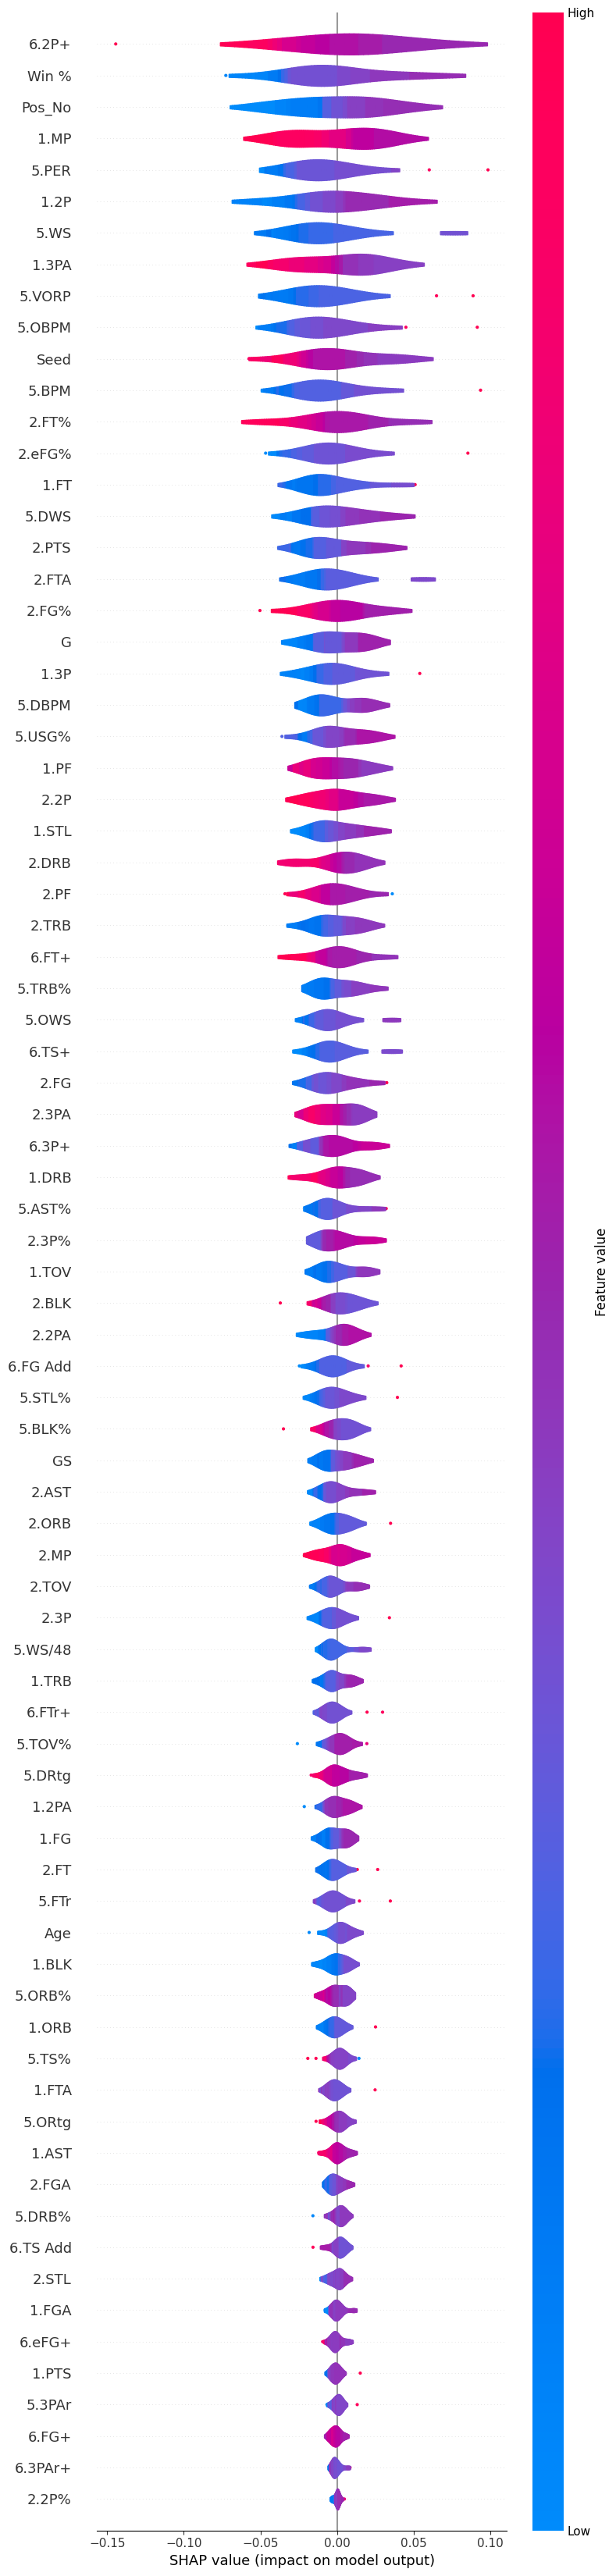

In [24]:
explainer = shap.Explainer(model.predict, normed_test_data)
shap_values = explainer(normed_test_data)
shap.summary_plot(shap_values, test, feature_names=test.columns ,plot_type='violin', max_display=len(test.columns))

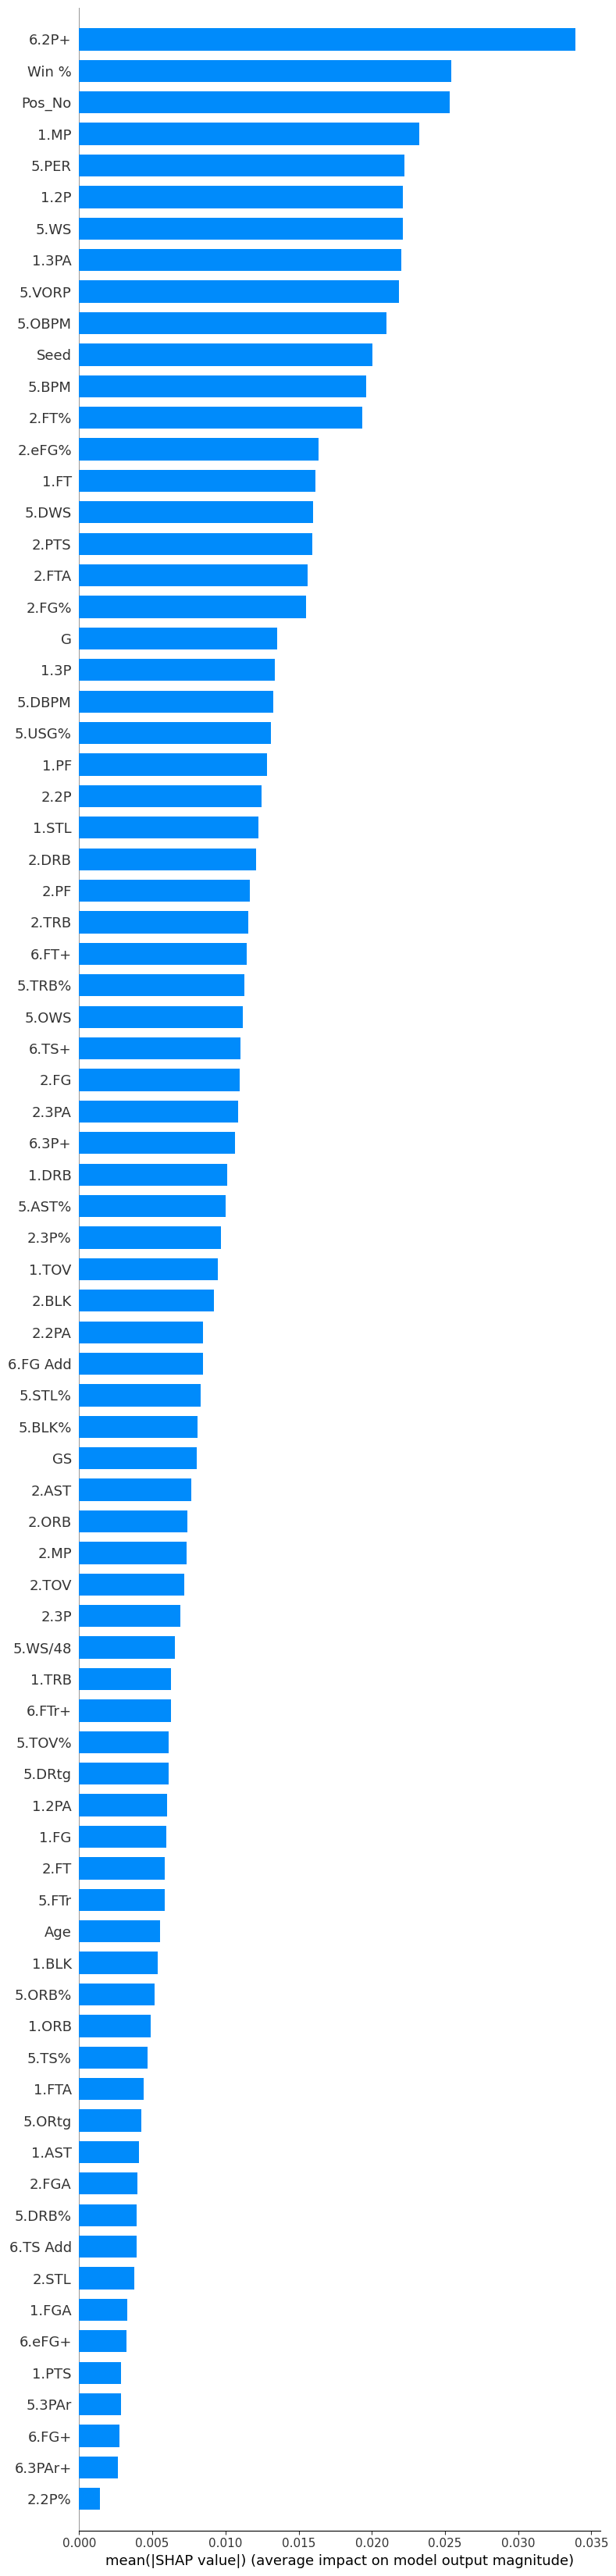

In [25]:
shap.summary_plot(shap_values, test, feature_names=test.columns ,plot_type='bar', max_display=len(test.columns))